# EDA on Netflix

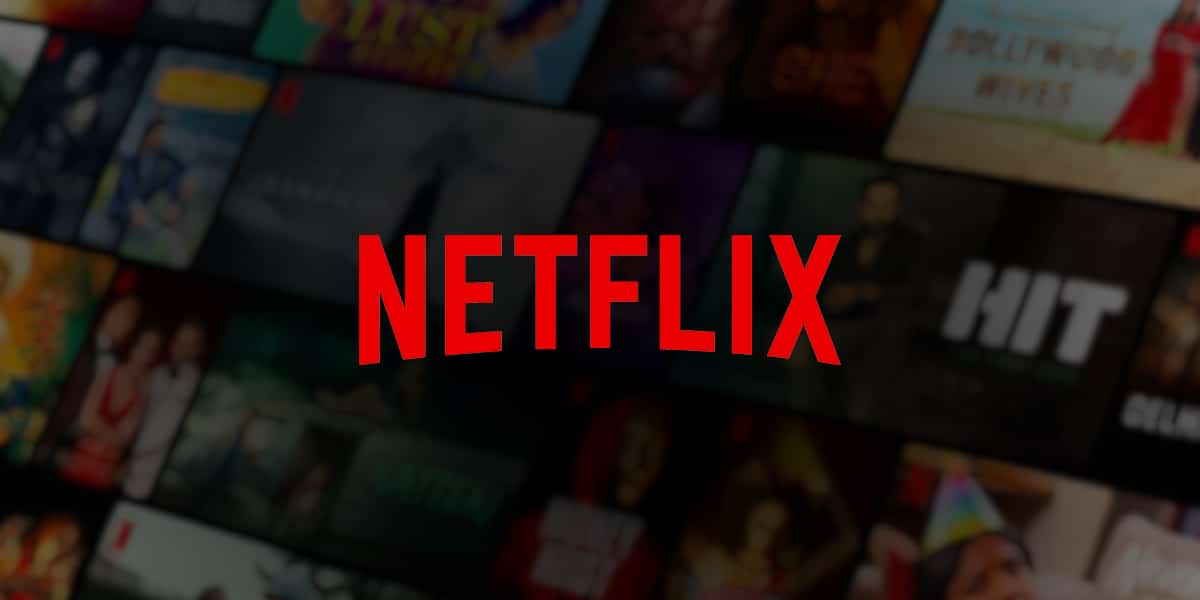

# Introduction

Thanks to the rise of streaming services, the way people consume entertainment has changed dramatically in recent years. Netflix is undeniably the biggest leader in the streaming world with a total global subscriber count of 232.5 million. In this project, I will explore the Netflix dataset through visualizations and graphs using python libraries, matplotlib and seaborn. I used Netflix Movies and TV Shows dataset from Kaggle. The dataset consists of listings of all TV Shows and Movies available on Netflix as of mid-2021.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

In [2]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

C:\Users\eunbi\AppData\Local\Temp\ipykernel_25244\2578555594.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("retina")


# Table of Contents

1. Data Preparation and Cleaning
2. Exploratory Analysis and Visualization
3. Conclusions

# Data Preparation and Cleaning

## Loading the Dataset

In [3]:
netflix = pd.read_csv(r"C:\Users\eunbi\Desktop\DS\Projects\Netflix titles EDA\netflix_titles.csv")
netflix.shape

(8807, 12)

In [4]:
netflix.nunique()

show_id         8807
type               2
title           8807
director        4528
cast            7692
country          748
date_added      1767
release_year      74
rating            17
duration         220
listed_in        514
description     8775
dtype: int64

I loaded the CSV file using Pandas Library and named the imported dataset as netflix. The dataset contains 8807 different movie/TVshow data: 6126 Movie data and 2664 TV Show data. The columns consist of 12 typical movie/TVshows descriptions, such as type, title, director, cast, country, date added and release year. 


Let's look at the first five data.

In [5]:
netflix.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


We can see that there are NaN values in some columns.

## Handling missing data
Let's have a look at the missing data.

In [6]:
netflix.isnull().sum().sum()

4307

In [7]:
netflix.isnull().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

Text(0.5, 1.0, 'Visualization of the Nullity of The Data')

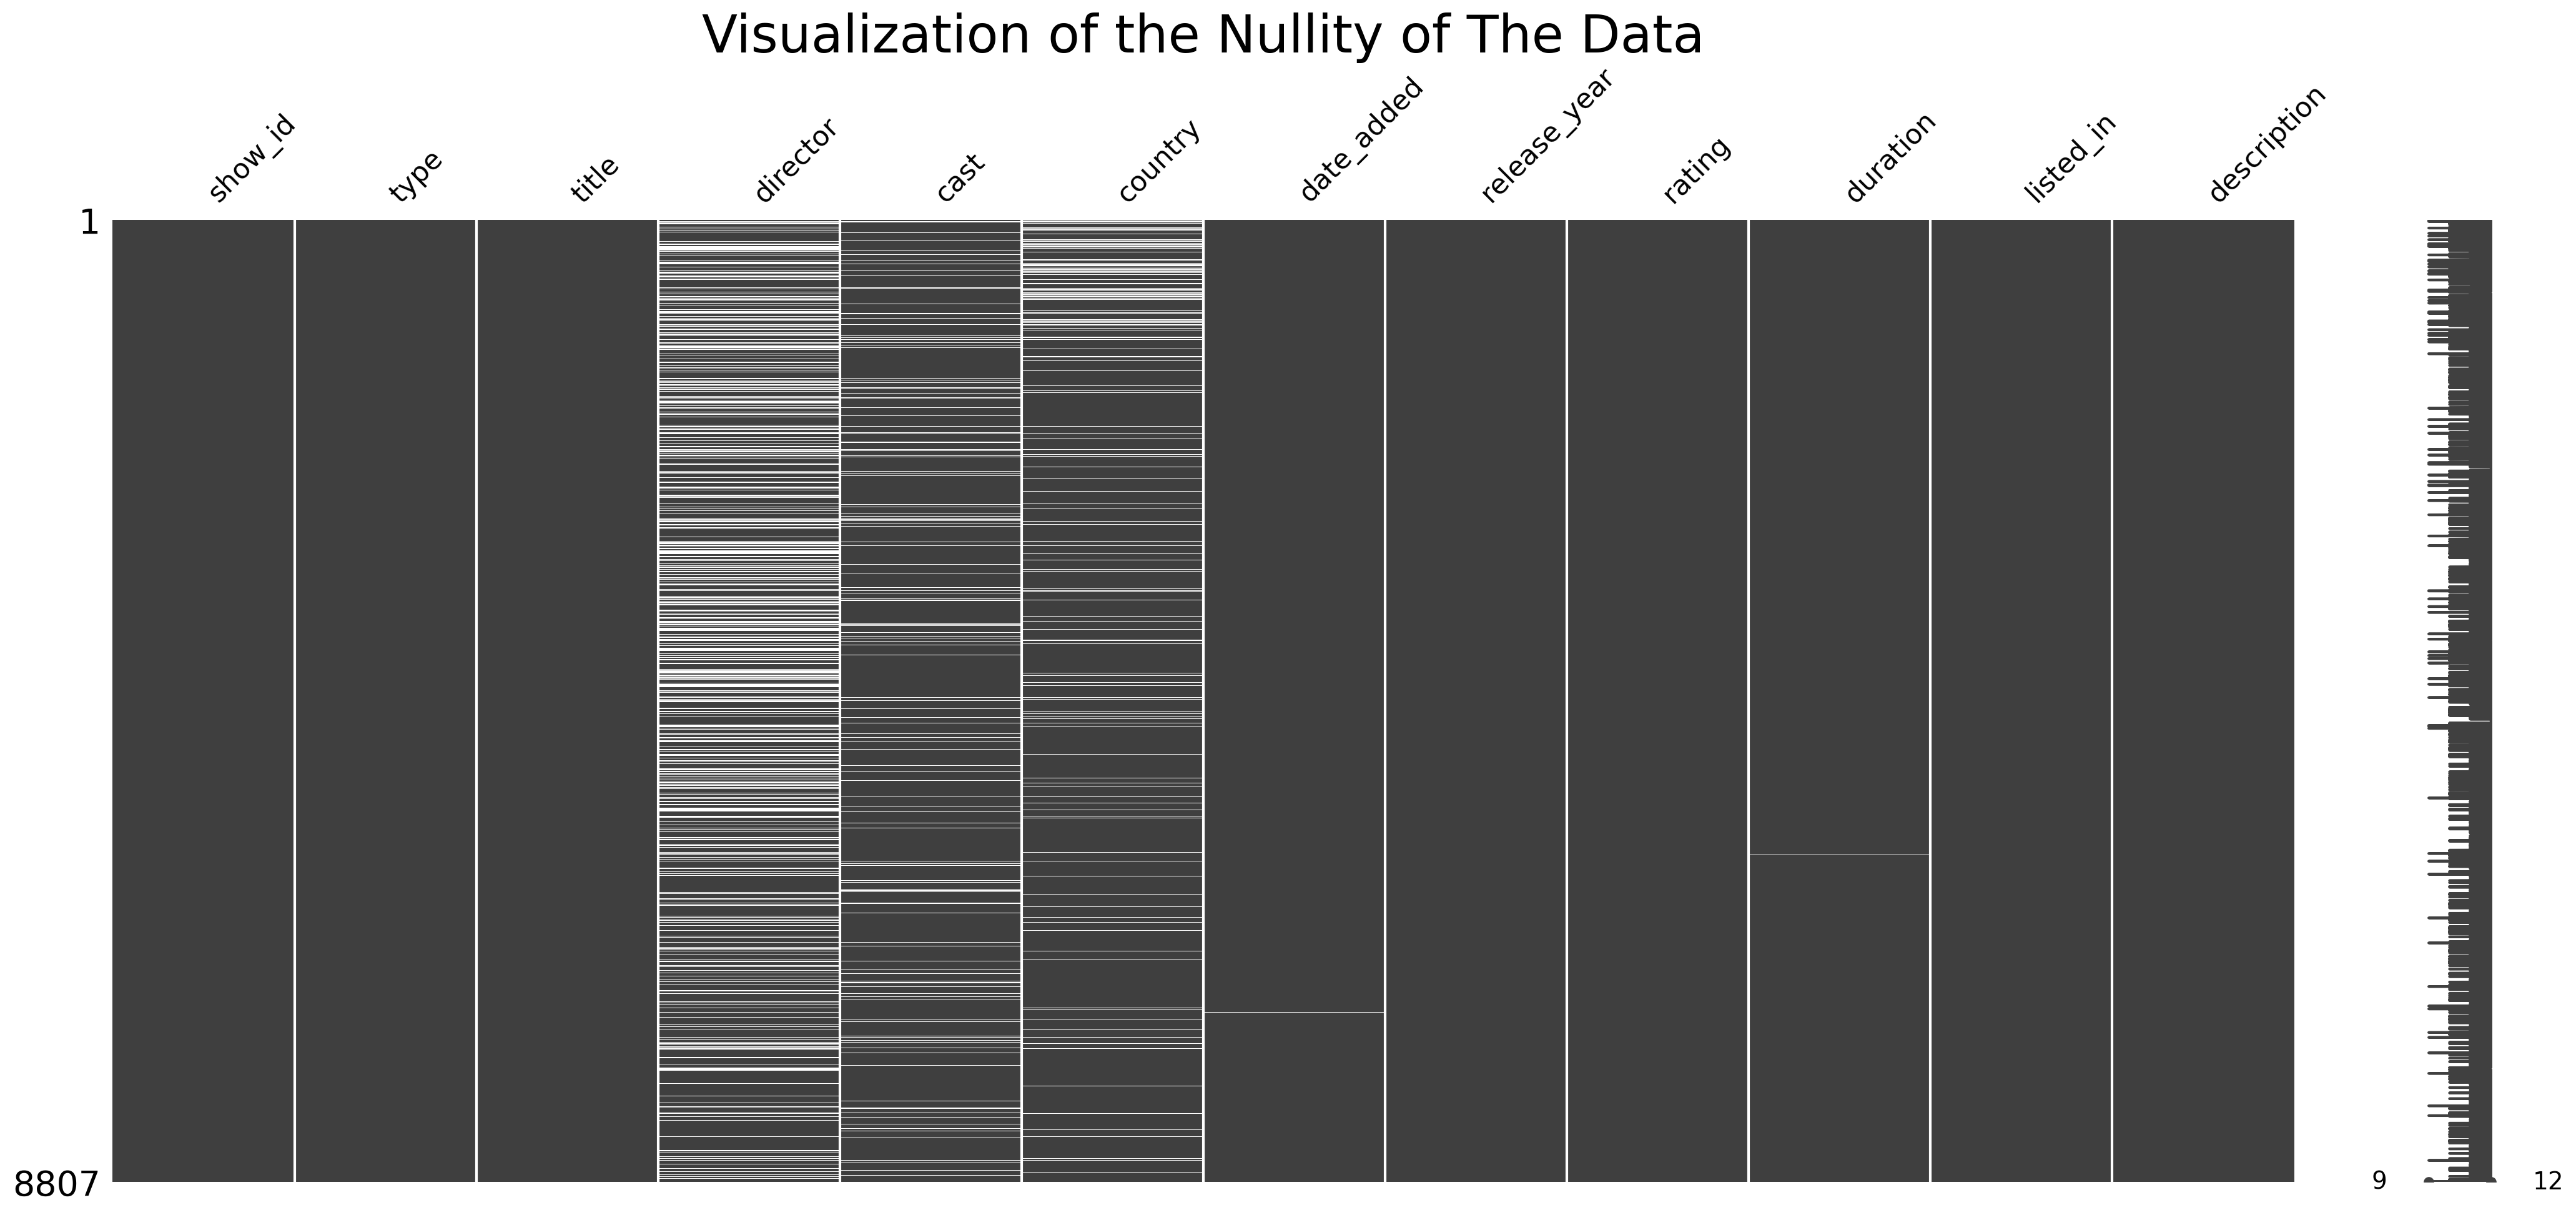

In [8]:
import missingno as msno

msno.matrix(netflix)
plt.title("Visualization of the Nullity of The Data", fontsize=30)

There are a total of 4307 missing values in the data. The visualization above shows that there are a lot of missing values in "director", "cast" and "country" columns. "data_added", "rating" and "duration" also have a few missing values.

The easiest way to get rid of them would be to delete the rows with the missing data. However, this is not the best option for this EDA. Since the number of missing values is large, dropping them would result in a significant loss of information. 

For the columns containing the majority of null values, such as "director", "cast", "country" and "rating", I chose to fill each missing value with 'unavailable' using fillna() function. "date_added", "duration" and "rating" can be dropped from the dataset because they contain an insignificant portion of the data.

In [9]:
netflix["director"] = netflix["director"].fillna("Unavailable")
netflix["cast"] = netflix["cast"].fillna("Unavailable")
netflix["country"] = netflix["country"].fillna("Unavailable")
netflix.dropna(subset=["date_added", "duration", "rating"], inplace=True)

In [10]:
netflix.isnull().sum()

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

In [11]:
netflix.shape

(8790, 12)

Finally, we can see that there are no more missing values in the data. The data size is reduced to 8790.

## Dates data
The datatype of "date_added" is object type. Transforming this variable to datetime data will be helpful. I will extract year and month from "date added" and add new columns "year_added" and "month_added".

In [12]:
netflix["date_added"] = pd.to_datetime(netflix["date_added"])
netflix["year_added"] = netflix["date_added"].dt.year
netflix["month_added"] = netflix["date_added"].dt.month
netflix.head(1)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,Unavailable,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",2021,9


## Unnesting columns

Some columns, such as "cast" and "country", contain a list of string values. Unnesting these columns will be possible. First, I want to create separate lines for each cast member in a movie.

In [13]:
# unnesting "cast" columns
constraint=netflix["cast"].apply(lambda x: str(x).split(', ')).tolist()
actors_un = pd.DataFrame(constraint,index=netflix["title"])
actors_un = actors_un.stack()
actors_un = pd.DataFrame(actors_un.reset_index())
actors_un.rename(columns={0:'Actors'},inplace=True)
actors_un.drop(['level_1'],axis=1,inplace=True)
actors_un.head()

,title,Actors
0,Dick Johnson Is Dead,Unavailable
1,Blood & Water,Ama Qamata
2,Blood & Water,Khosi Ngema
3,Blood & Water,Gail Mabalane
4,Blood & Water,Thabang Molaba


A lot of contents are listed in multiple genres. I want to create separate lines for each genre as well.

In [14]:
# unnesting "listed_in" columns
constraint2 = netflix["listed_in"].apply(lambda x: str(x).split(', ')).tolist()
genres_un = pd.DataFrame(constraint2,index=netflix["title"])
genres_un = genres_un.stack()
genres_un = pd.DataFrame(genres_un.reset_index())
genres_un.rename(columns={0:"Genre"},inplace=True)
genres_un.drop(["level_1"],axis=1,inplace=True)
genres_un.head()

,title,Genre
0,Dick Johnson Is Dead,Documentaries
1,Blood & Water,International TV Shows
2,Blood & Water,TV Dramas
3,Blood & Water,TV Mysteries
4,Ganglands,Crime TV Shows


Lastly, I'm going to create separate lines for each country in a movie.

In [15]:
# unnesting "country" columns
constraint3 = netflix["country"].apply(lambda x: str(x).split(', ')).tolist()
country_un = pd.DataFrame(constraint3, index=netflix["title"])
country_un = country_un.stack()
country_un = pd.DataFrame(country_un.reset_index())
country_un.rename(columns={0:"Country"}, inplace=True)
country_un.drop(["level_1"], axis=1, inplace=True)
country_un.head()

,title,Country
0,Dick Johnson Is Dead,United States
1,Blood & Water,South Africa
2,Ganglands,Unavailable
3,Jailbirds New Orleans,Unavailable
4,Kota Factory,India


In [16]:
# merge unnested actors data with unnested genres data
netflix_un = actors_un.merge(genres_un, on=["title"], how="inner")
# merge the above data with unnested  countries data
netflix_un = netflix_un.merge(country_un, on=["title"], how="inner")
# merge the anove data with the original data 
cols = ["show_id", "director", "type", "title", "date_added", "year_added", "month_added", "release_year", "rating", "duration"]
netflix_new = netflix_un.merge(netflix[cols], on=["title"], how="left")
netflix_new.head()

,title,Actors,Genre,Country,show_id,director,type,date_added,year_added,month_added,release_year,rating,duration
0,Dick Johnson Is Dead,Unavailable,Documentaries,United States,s1,Kirsten Johnson,Movie,2021-09-25,2021,9,2020,PG-13,90 min
1,Blood & Water,Ama Qamata,International TV Shows,South Africa,s2,Unavailable,TV Show,2021-09-24,2021,9,2021,TV-MA,2 Seasons
2,Blood & Water,Ama Qamata,TV Dramas,South Africa,s2,Unavailable,TV Show,2021-09-24,2021,9,2021,TV-MA,2 Seasons
3,Blood & Water,Ama Qamata,TV Mysteries,South Africa,s2,Unavailable,TV Show,2021-09-24,2021,9,2021,TV-MA,2 Seasons
4,Blood & Water,Khosi Ngema,International TV Shows,South Africa,s2,Unavailable,TV Show,2021-09-24,2021,9,2021,TV-MA,2 Seasons


Now, it's finally time to explore the data and create visualizations.

# Exploratory Analysis and Visualization

## How many Movies and TV Shows on Netflix?

The dataset consists of 6126 movie data and 2664 TV show data. We already know that there are more movie data than TV show data, but I want to compare them with ratio. Pie chart would be a good choice for the proportions of categorical data.

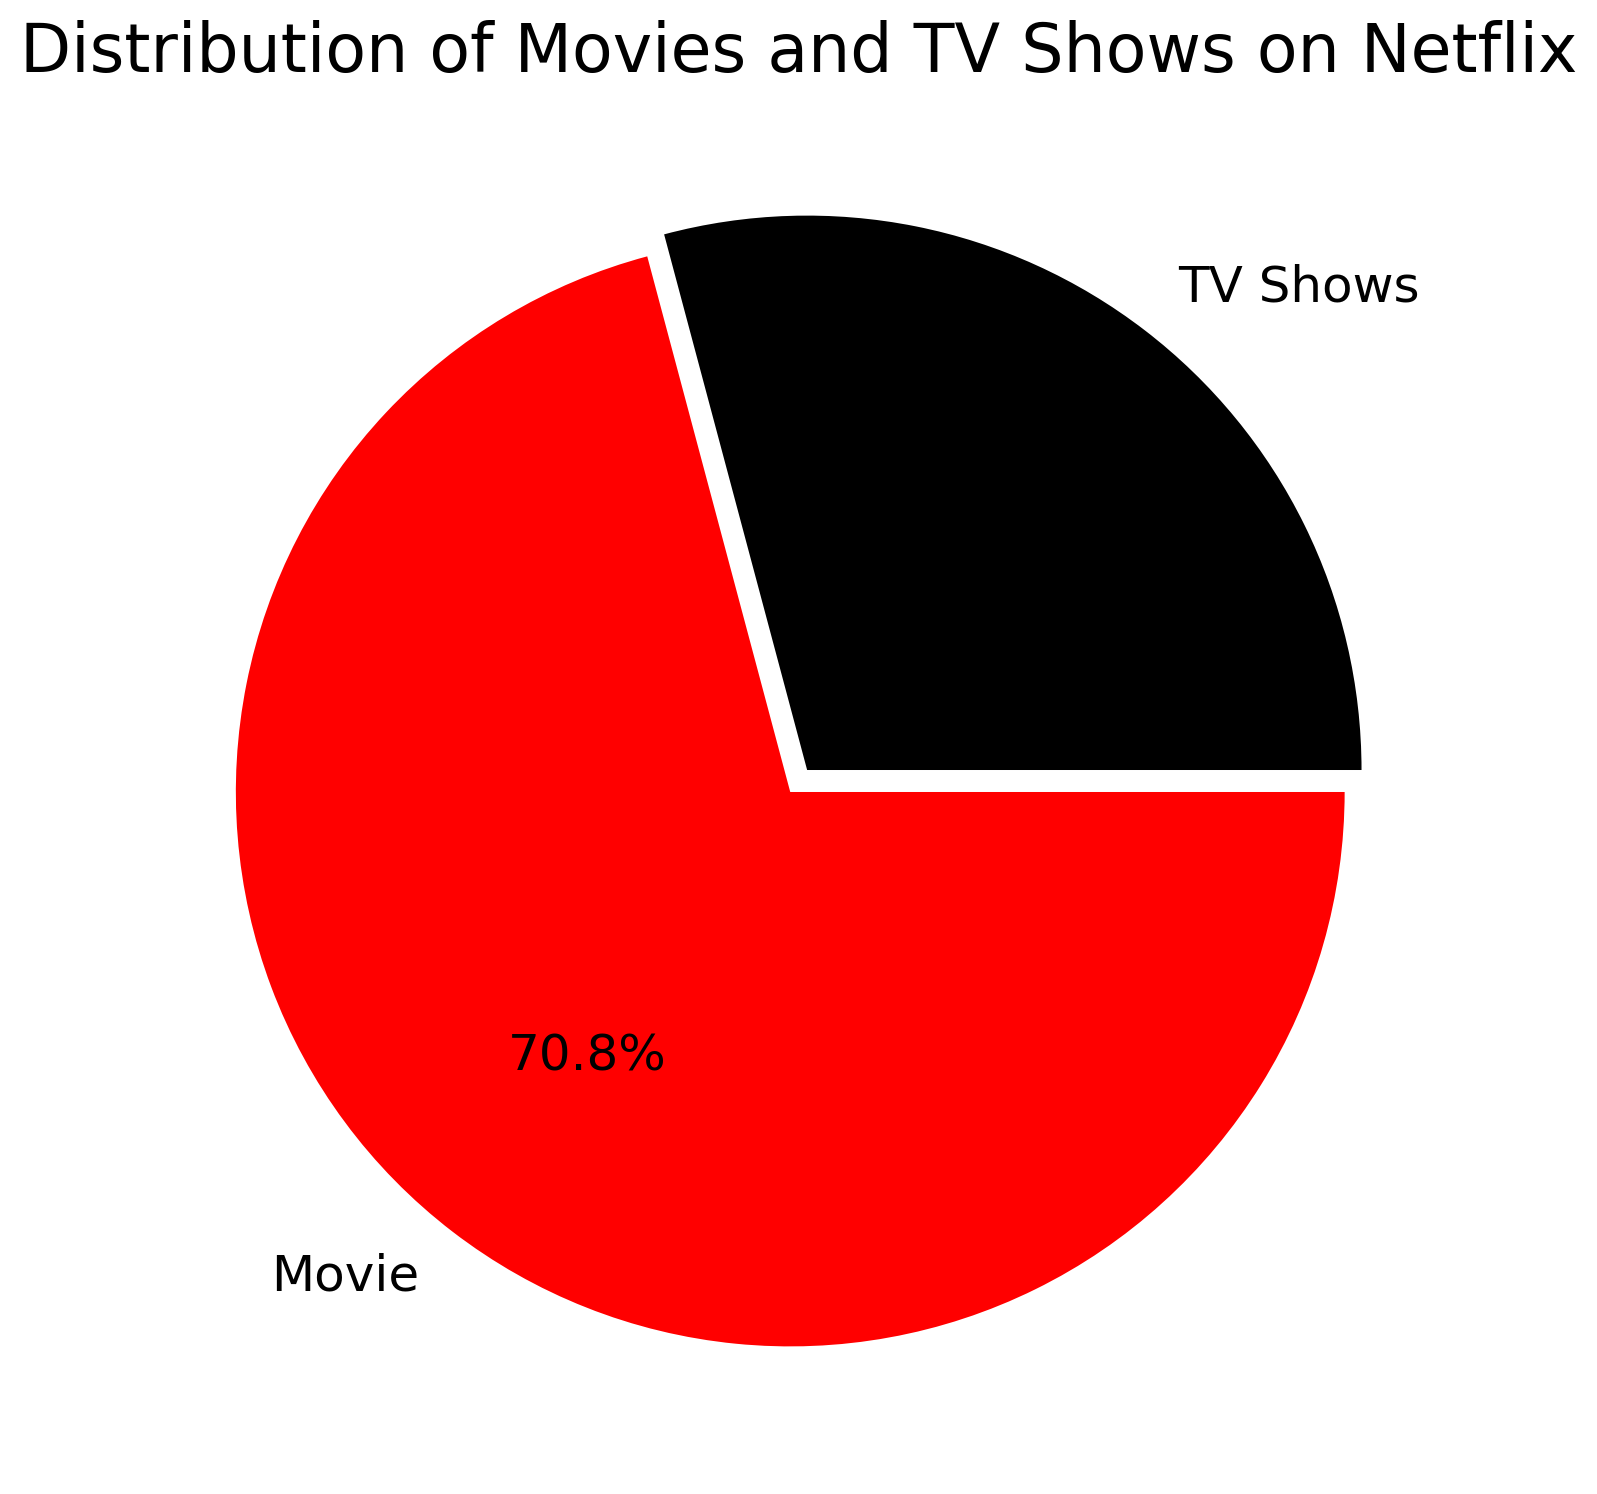

In [17]:
# Calculate the ratio of Movies and TV Shows
label = ["Movie", "TV Shows"]
mtratio = netflix_new["type"].value_counts(normalize=True)
# Draw a pie chart indicating the percentage of Moves and TV Shows
plt.rcParams["figure.figsize"] = (15,9)
plt.pie(mtratio, labels=label, colors=["red", "black"], counterclock=False, 
        explode=(0.025,0.025), textprops={'fontsize': 18},
        autopct='%.1f%%')
plt.title("Distribution of Movies and TV Shows on Netflix", fontsize=24)
plt.show()

There are more than 6000 movies and almost 3,000 TV shows on Netflix, with movies being the majority. There are far more movie titles (69.7%) than TV shows titles (30.3%).

## How has the amount of content on Netflix changed over time?
Now, I will explore the amount of content Netflix has added over the previous years. I will extract year and month from "date added" and add new columns "year_added" and "month_added". 

In [19]:
# Count the amount of content by "year_added" and "type"
year_type = netflix_new.groupby(["year_added", "type"])["title"].count().unstack()
year_type = year_type.reset_index()
year_type = year_type.fillna(0)
year_type["Total"] = year_type["Movie"] + year_type["TV Show"]

C:\Users\eunbi\AppData\Local\Temp\ipykernel_25244\3074331866.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  matplotlib.style.use("seaborn-white")


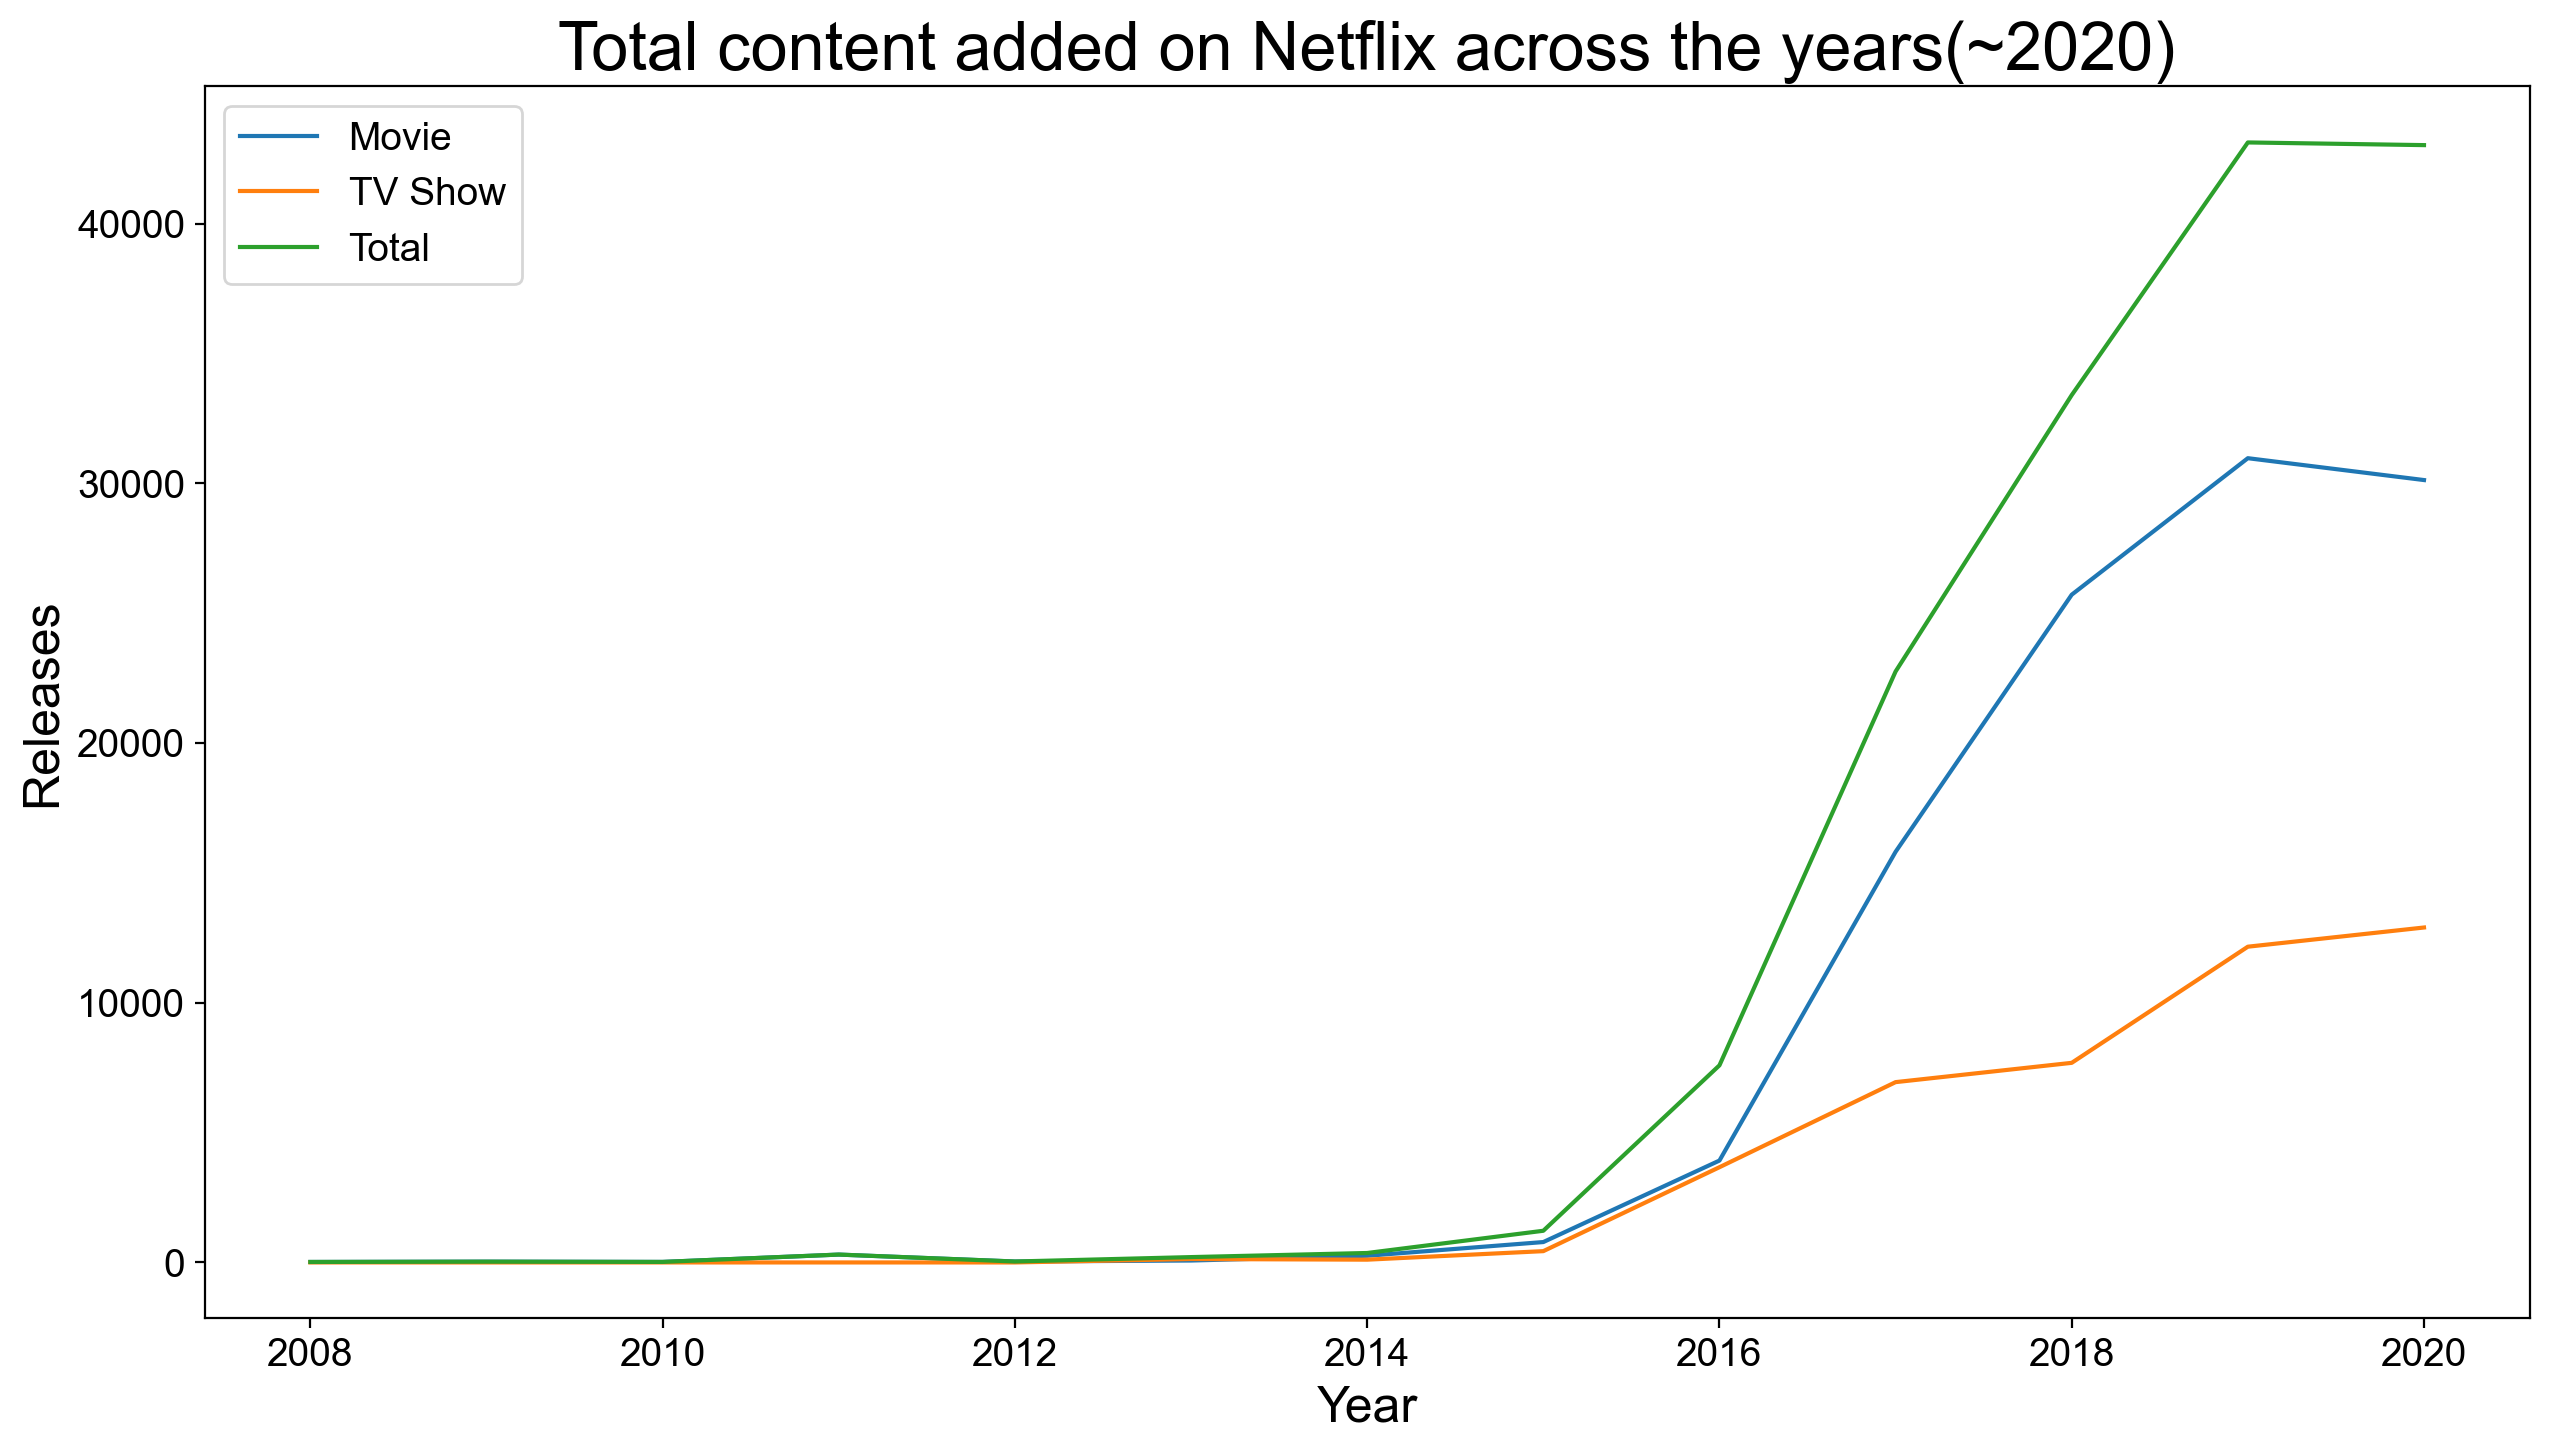

In [20]:
# Draw a line plot with "year_added" on the x-axis
yeartype_plt = year_type[:-1].plot.line(x="year_added", fontsize=14,
                                          figsize=(15,8), 
                                          title="Total content added on Netflix across the years(~2020)")
yeartype_plt.title.set_size(24)
yeartype_plt.legend(title="", fontsize=14)
yeartype_plt.set_xlabel("Year", fontsize=18)
yeartype_plt.set_ylabel("Releases", fontsize=18)
matplotlib.style.use("seaborn-white")

Based on the line plot above, we can say that Netflix started growing its business as a streaming platform from 2013. Since 2015, the amount of content added has been rapidly increasing. Besides, it clearly appears that Netflix has increasingly focused on TV shows rather than movies in recent years. While the number of TV show releases kept increasing, the amount of increase in the number of movie releases has reduced since 2017 and the number even dropped in 2020.

In [21]:
year_month = pd.pivot_table(netflix_new, index="month_added", columns="year_added", values="title", aggfunc="count")
year_month = year_month.fillna(0)
year_month.style.background_gradient("Reds")

year_added,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
month_added,,,,,,,,,,,,,,
1,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,91.000000,1.000000,875.000000,1499.000000,2372.000000,3454.000000,5790.000000,2883.000000
2,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,50.000000,44.000000,241.000000,1651.000000,1735.000000,2870.000000,2685.000000,2572.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,30.000000,0.000000,50.000000,283.000000,2135.000000,3537.000000,4060.000000,2712.000000,2396.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,37.000000,368.000000,1436.000000,2295.000000,3258.000000,3999.000000,4058.000000
5,0.000000,24.000000,0.000000,72.000000,0.000000,0.000000,0.000000,74.000000,273.000000,1618.000000,1746.000000,2525.000000,3346.000000,2936.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,101.000000,231.000000,2004.000000,1476.000000,3256.000000,3927.000000,4399.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,92.000000,671.000000,1438.000000,3456.000000,2883.000000,3058.000000,6400.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,30.000000,18.000000,45.000000,372.000000,2302.000000,3508.000000,2808.000000,2671.000000,4093.000000
9,0.000000,0.000000,0.000000,135.000000,0.000000,49.000000,1.000000,133.000000,689.000000,2428.000000,2652.000000,2615.000000,3852.000000,4270.000000


The table above shows the amount of netflix releases by month and year added. 
It seems that most Netflix TV shows and movies are typically more released in the second half of the year.

# Which country has most Netflix content?

Netflix offers internationally diverse content. Now, let's take a look at the countries in which Netflix contents are produced. 

In [22]:
# Top 10 countries
country_filtered = netflix_new.loc[netflix_new["Country"]!="Unavailable",]
countries = country_filtered.groupby(["Country"])["title"].nunique().reset_index()
countries = countries.sort_values(by="title", ascending=False).reset_index()
countries = countries.drop("index", axis=1)
countries.head(10)

,Country,title
0,United States,3680
1,India,1046
2,United Kingdom,803
3,Canada,445
4,France,393
5,Japan,316
6,Spain,232
7,South Korea,231
8,Germany,226
9,Mexico,169


C:\Users\eunbi\AppData\Local\Temp\ipykernel_25244\1056808559.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  matplotlib.style.use("seaborn-white")


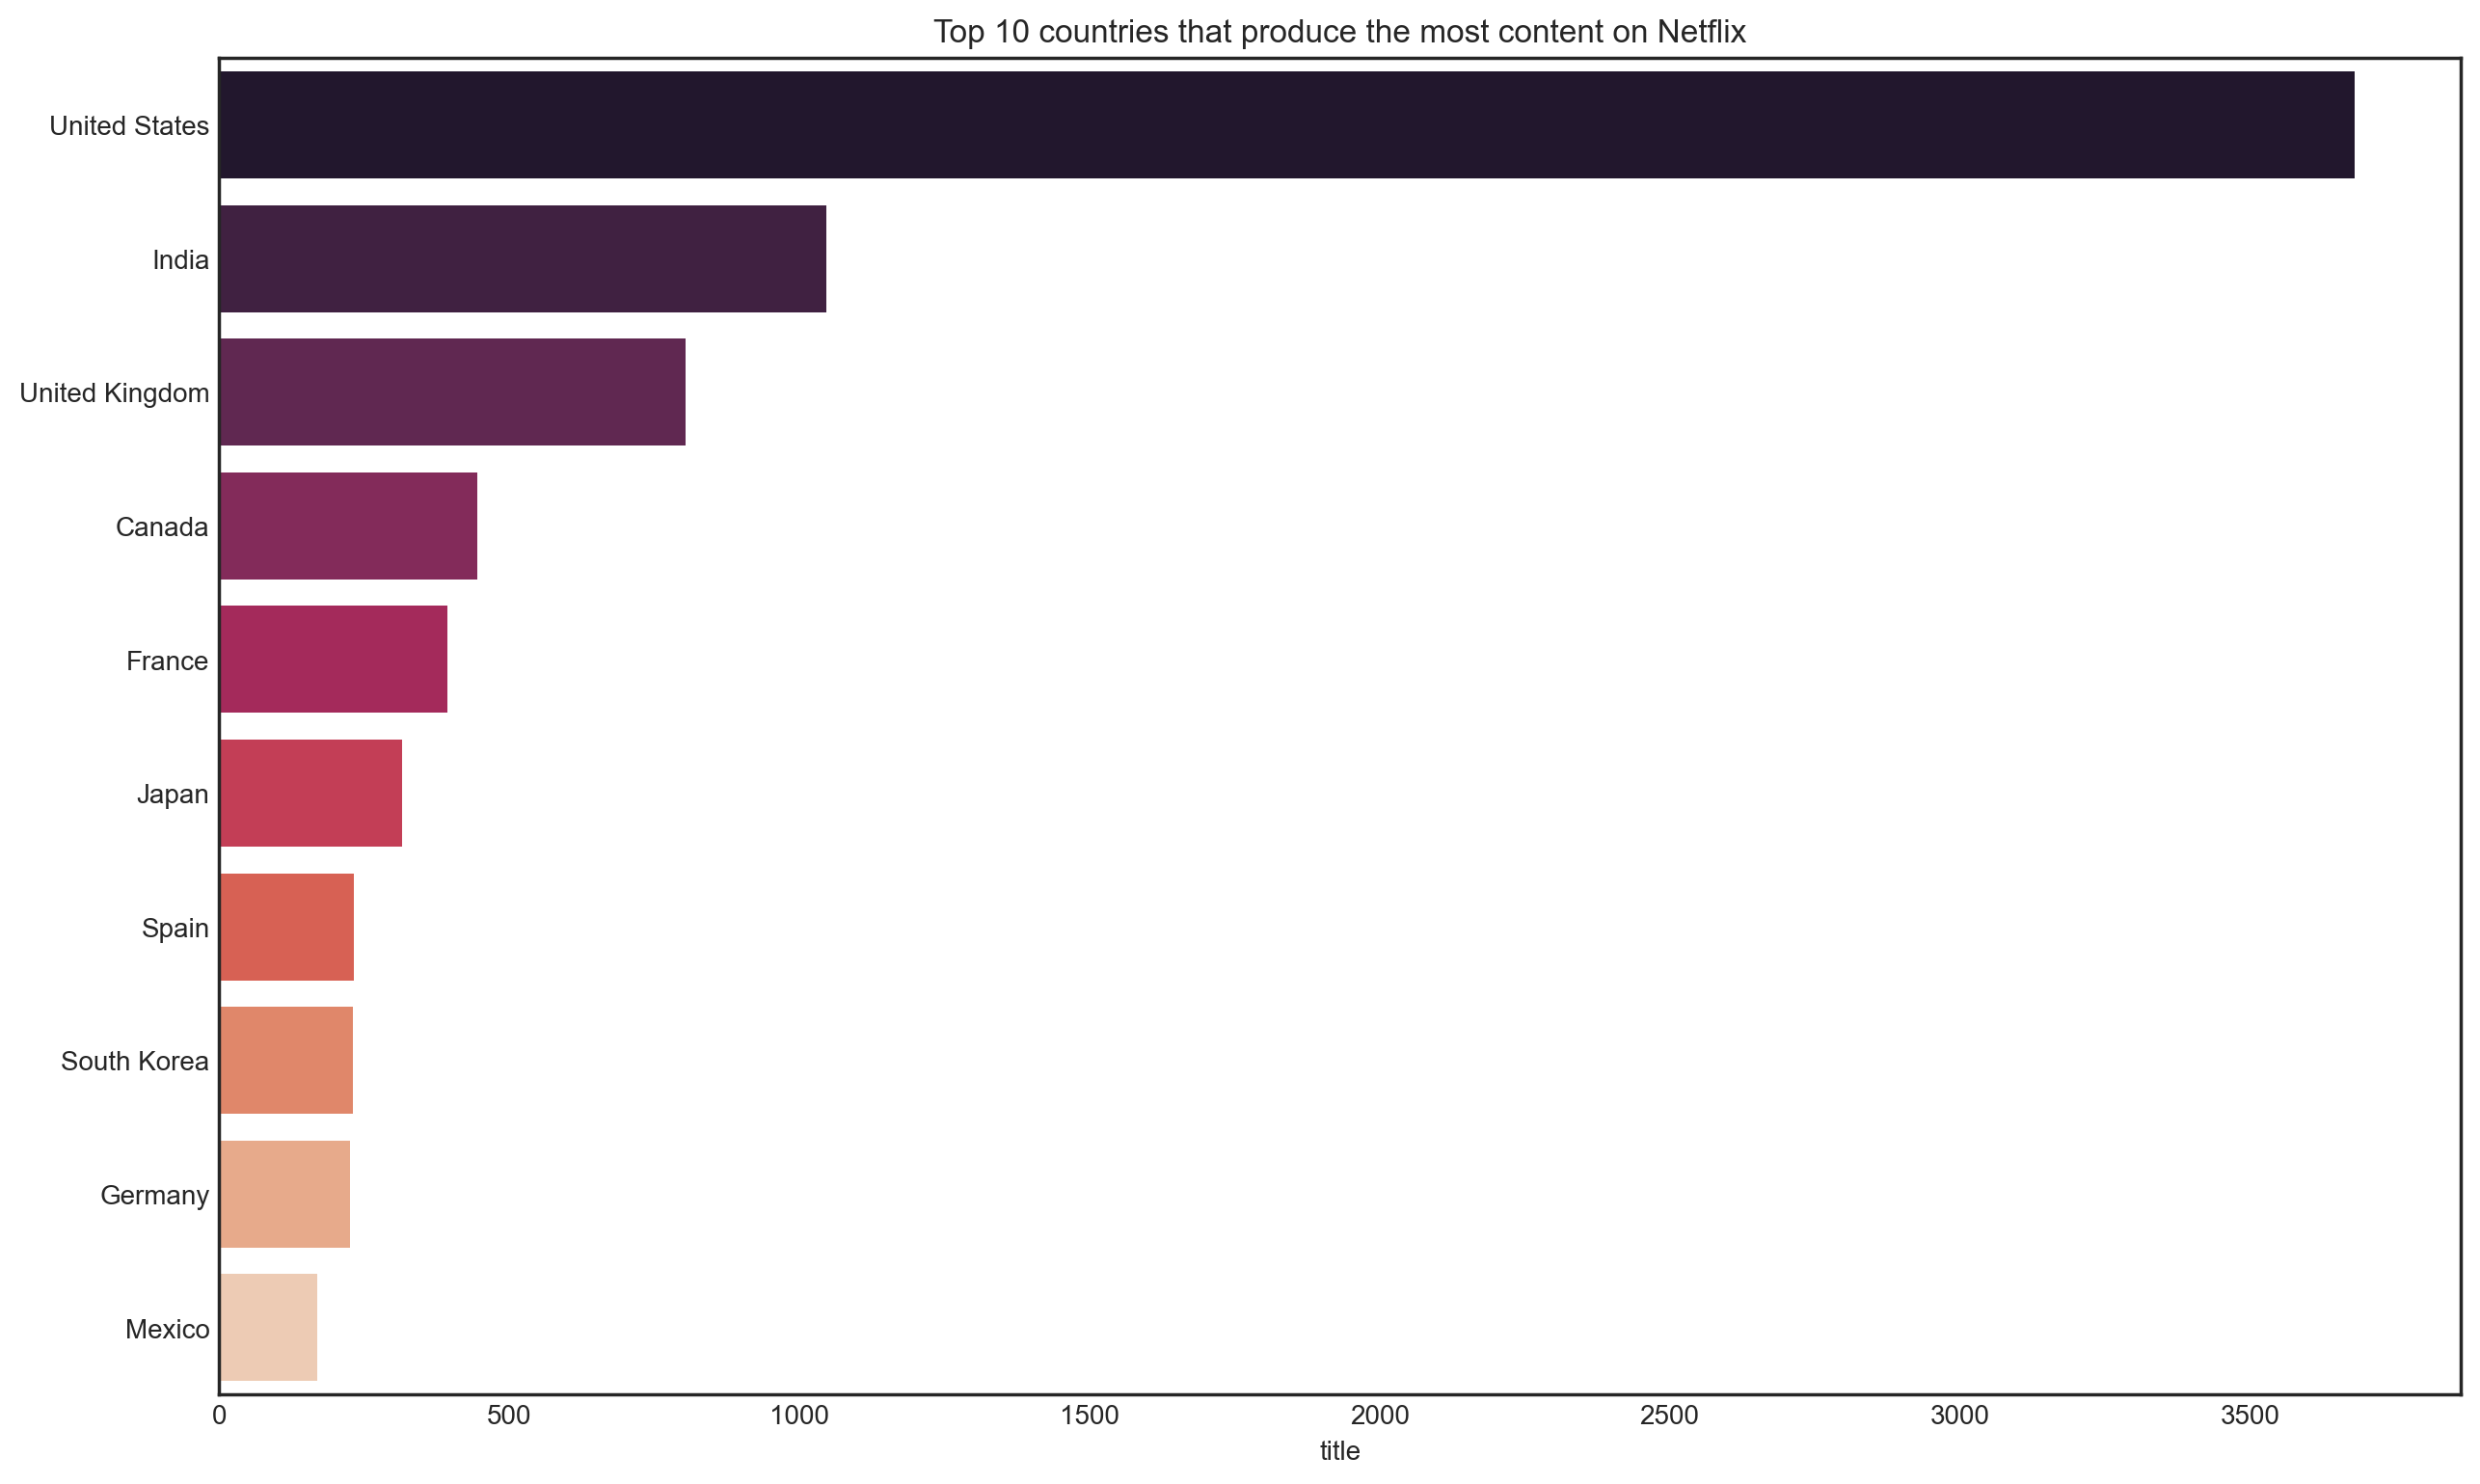

In [23]:
# Draw a barplot
countries_plt = sns.barplot(countries.head(10), y="Country", x="title", palette="rocket")
countries_plt.set_title("Top 10 countries that produce the most content on Netflix")
countries_plt.set_ylabel("")
sns.set(font_scale=1.9)
matplotlib.style.use("seaborn-white")

The majority of Netflix contents obviously come from United States. The second biggest contributor is India. The two countries with the largest film industry, Hollywood and Bollywood.

In [24]:
# Top five countries
topfive_countries = countries["Country"].head().tolist()
topfive_countries_df = country_filtered.loc[country_filtered["Country"].isin(topfive_countries),]
# Group by 'year_added' & 'country' and count the number of titles
year_country = pd.pivot_table(topfive_countries_df, index="year_added", columns = "Country", values = "title", aggfunc=pd.Series.nunique).reset_index()
year_country.columns = ["year_added", "Canada", "France", "India", "United Kingdom", "United States"]
year_country = year_country.fillna(0)
year_country.head()

,year_added,Canada,France,India,United Kingdom,United States
0,2008,0.0,0.0,0.0,0.0,2.0
1,2009,0.0,0.0,0.0,0.0,1.0
2,2010,0.0,0.0,0.0,0.0,1.0
3,2011,0.0,2.0,0.0,1.0,12.0
4,2012,0.0,0.0,0.0,0.0,3.0


C:\Users\eunbi\AppData\Local\Temp\ipykernel_25244\3916927087.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  matplotlib.style.use("seaborn-white")


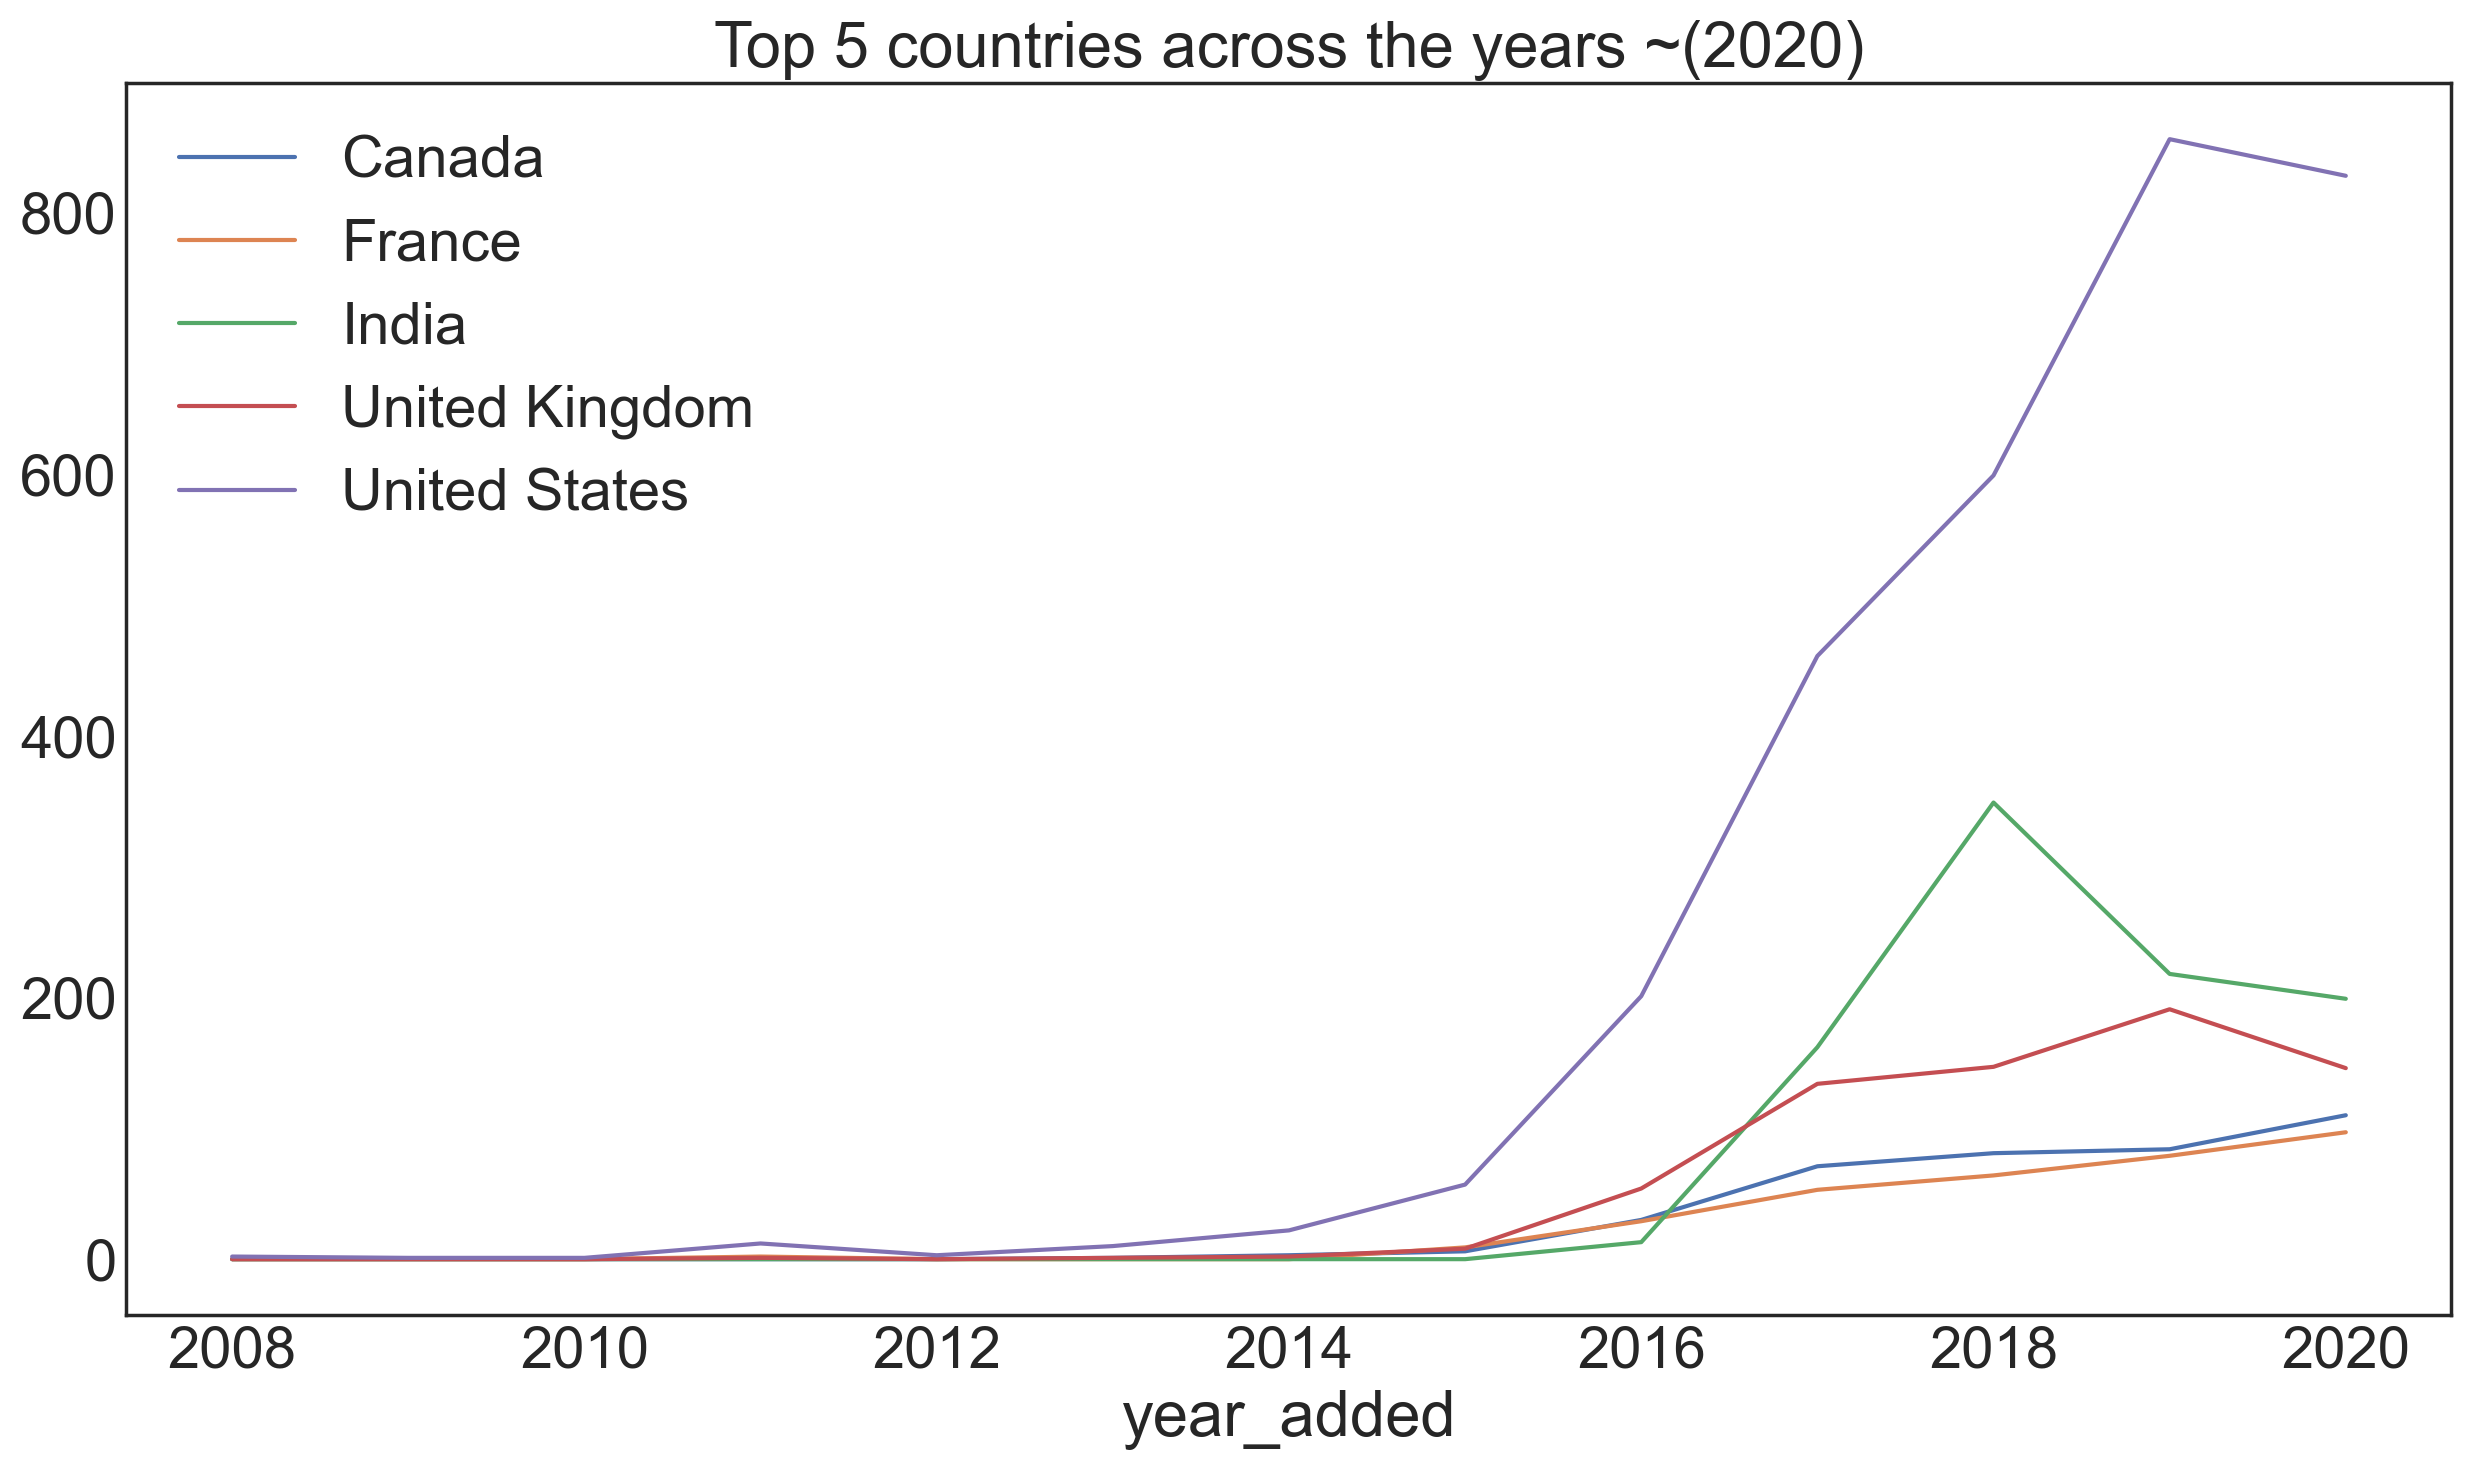

In [25]:
# Draw a line chart
year_plt = year_country[:-1].plot.line(x="year_added", figsize=(15,8))
year_plt.set_title("Top 5 countries across the years ~(2020)")
sns.set(font_scale=1.8)
matplotlib.style.use("seaborn-white")

The gap between the number of American contents and the number of Indian contents started to widen as the number of Indian contents significantly dropped in 2018. The number of UK contents started to drop, too. We can also see that the number of Japanese and French contents kept slightly increasing, suggesting that the demand for international contents has increased in recent years.

## Who has made the most movies on Netflix?

In [26]:
# Top 10 directors
director_filtered = netflix_new.loc[netflix_new["director"]!="Unavailable",]
directors = director_filtered.groupby(["director"])["title"].nunique().reset_index()
directors = directors.sort_values(by="title", ascending=False).reset_index()
directors = directors.drop("index", axis=1)
directors.head(10)

,director,title
0,Rajiv Chilaka,19
1,"Raúl Campos, Jan Suter",18
2,Suhas Kadav,16
3,Marcus Raboy,16
4,Jay Karas,14
5,Cathy Garcia-Molina,13
6,Jay Chapman,12
7,Youssef Chahine,12
8,Martin Scorsese,12
9,Steven Spielberg,11


C:\Users\eunbi\AppData\Local\Temp\ipykernel_25244\925380534.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  matplotlib.style.use("seaborn-white")


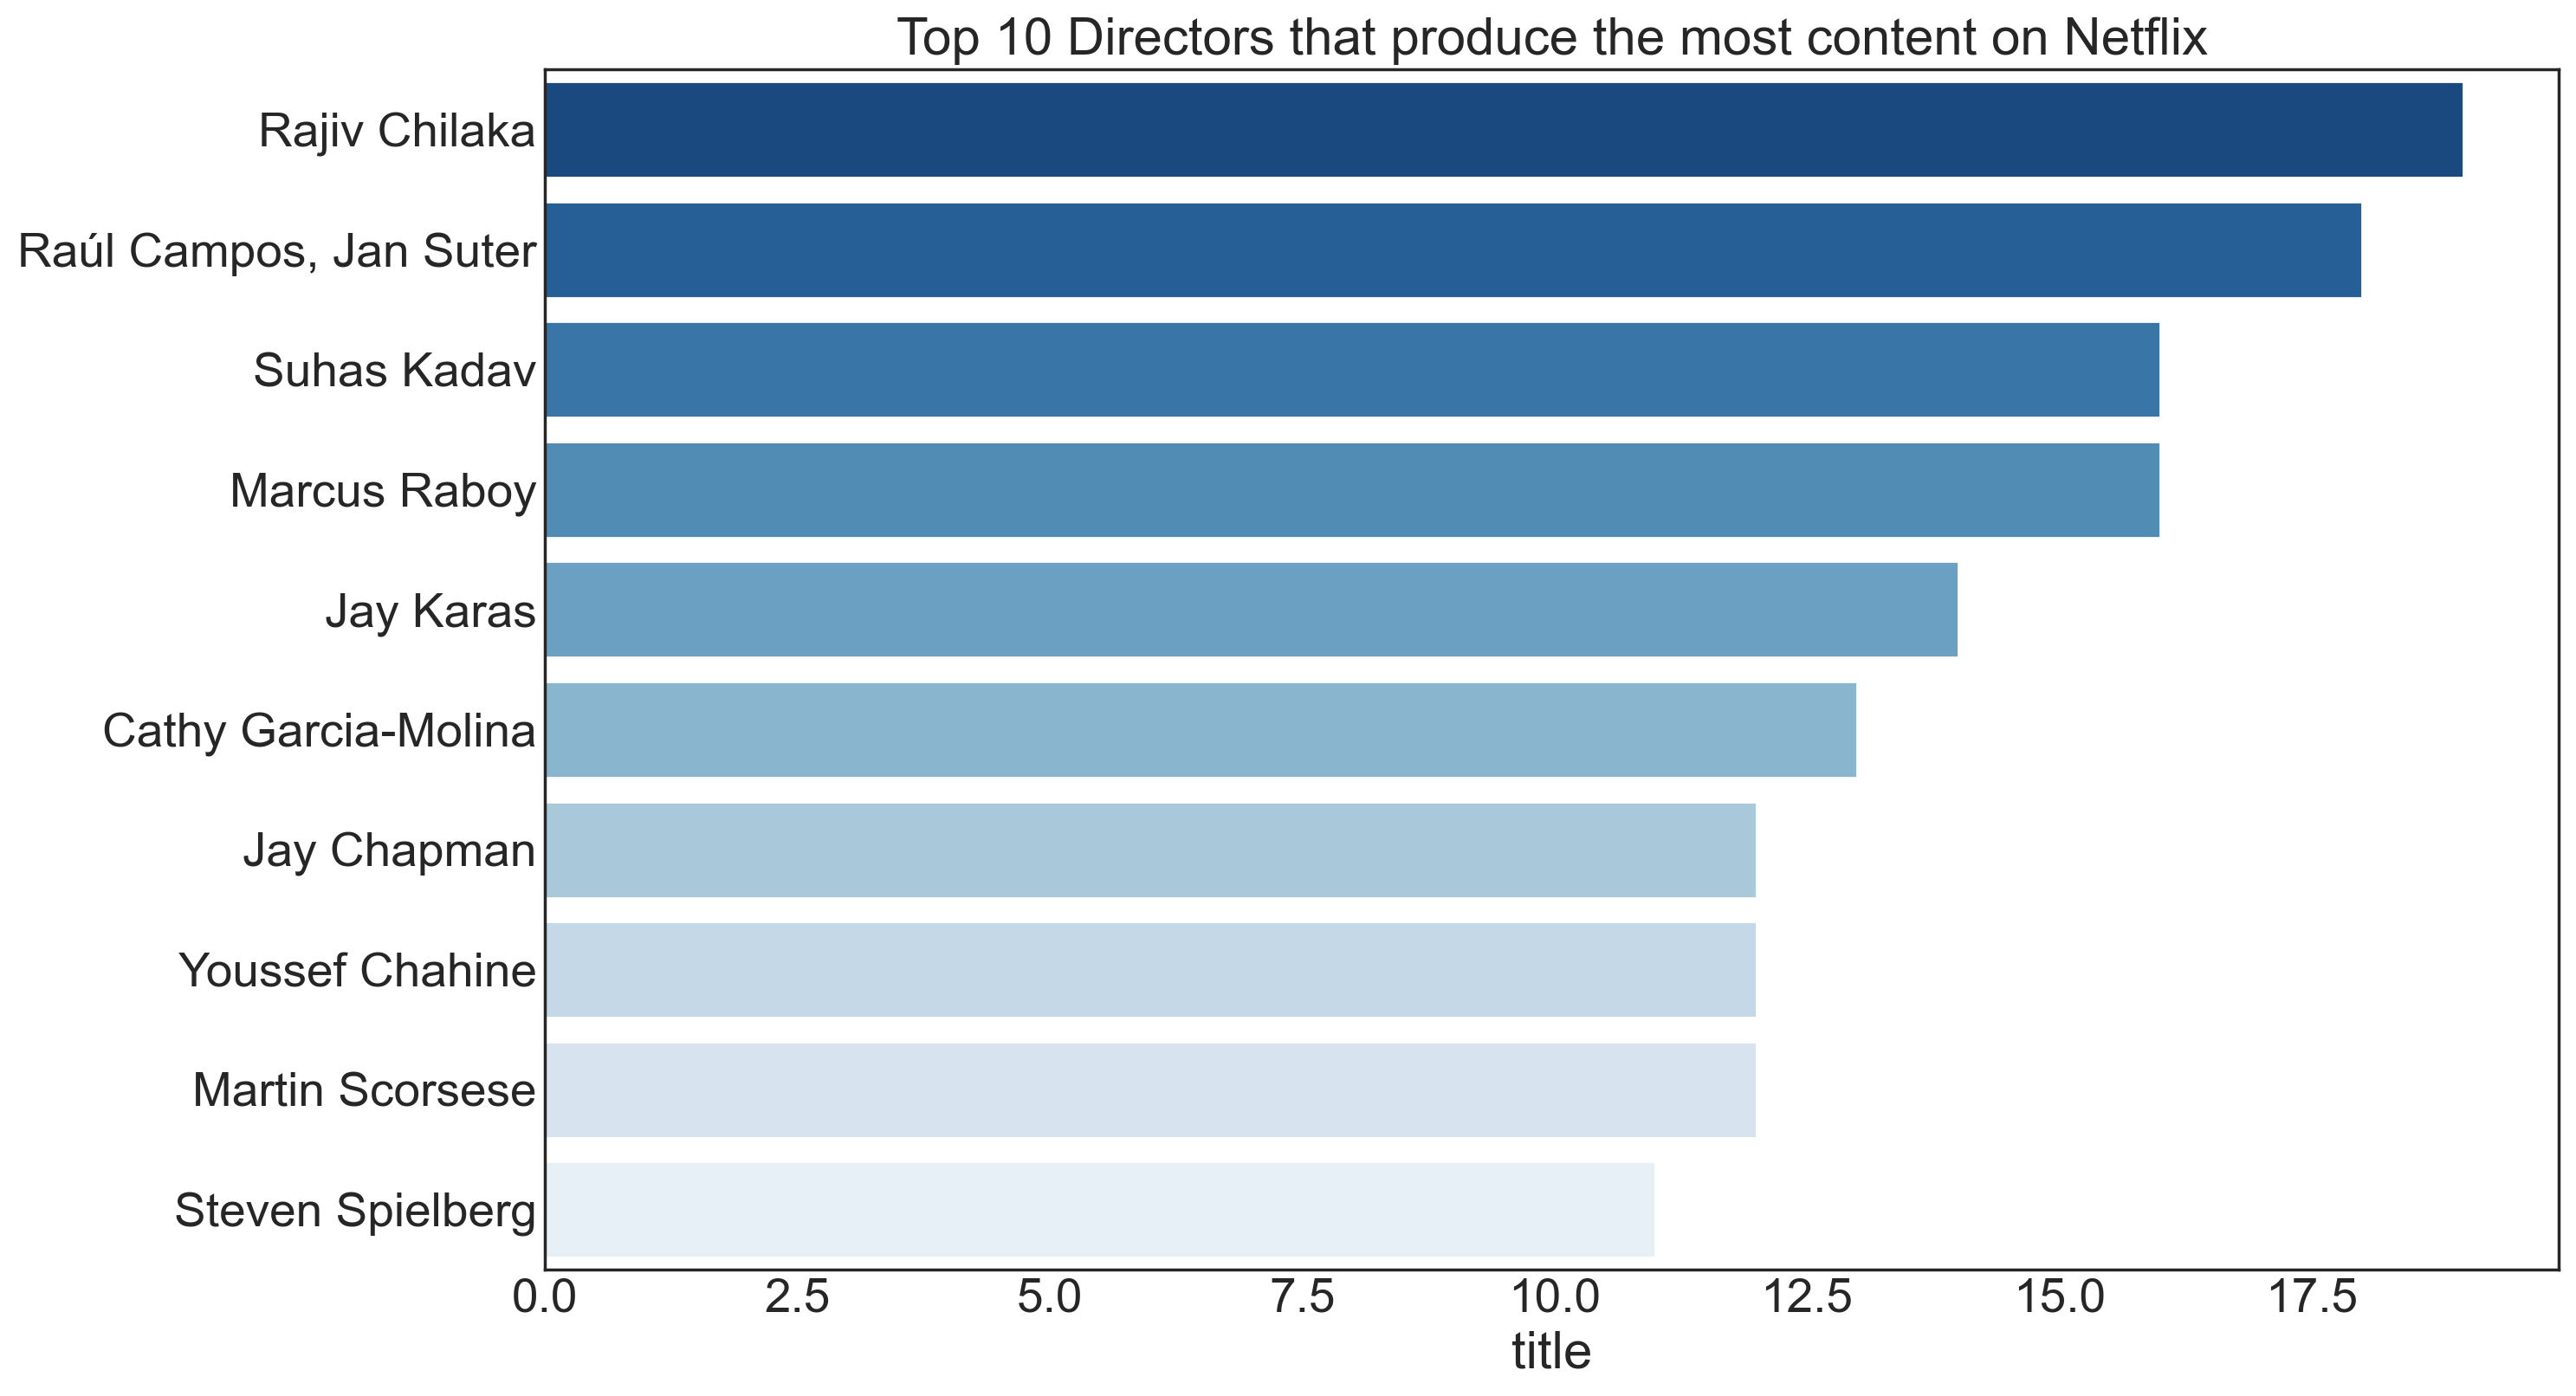

In [27]:
# Draw a barplot
directors_plt = sns.barplot(directors.head(10), y="director", x="title", palette="Blues_r")
directors_plt.set_title("Top 10 Directors that produce the most content on Netflix")
sns.set(font_scale=1.9)
directors_plt.set_ylabel("")
matplotlib.style.use("seaborn-white")

The directors on Netflix are internationally diverse. The most popular director, based on the number of titles, is Rajiv Chilaka. 

## What is the top genre on Netflix?
I want to explore what the most common genres on Netflix are.

In [28]:
# Top 10 genres
genres = netflix_new.groupby(["Genre"])["title"].nunique().reset_index()
genres = genres.sort_values(by="title", ascending=False).reset_index()
genres = genres.drop("index", axis=1)
genres.head(10)

,Genre,title
0,International Movies,2752
1,Dramas,2426
2,Comedies,1674
3,International TV Shows,1349
4,Documentaries,869
5,Action & Adventure,859
6,TV Dramas,762
7,Independent Movies,756
8,Children & Family Movies,641
9,Romantic Movies,616


C:\Users\eunbi\AppData\Local\Temp\ipykernel_25244\1746428977.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  matplotlib.style.use("seaborn-white")


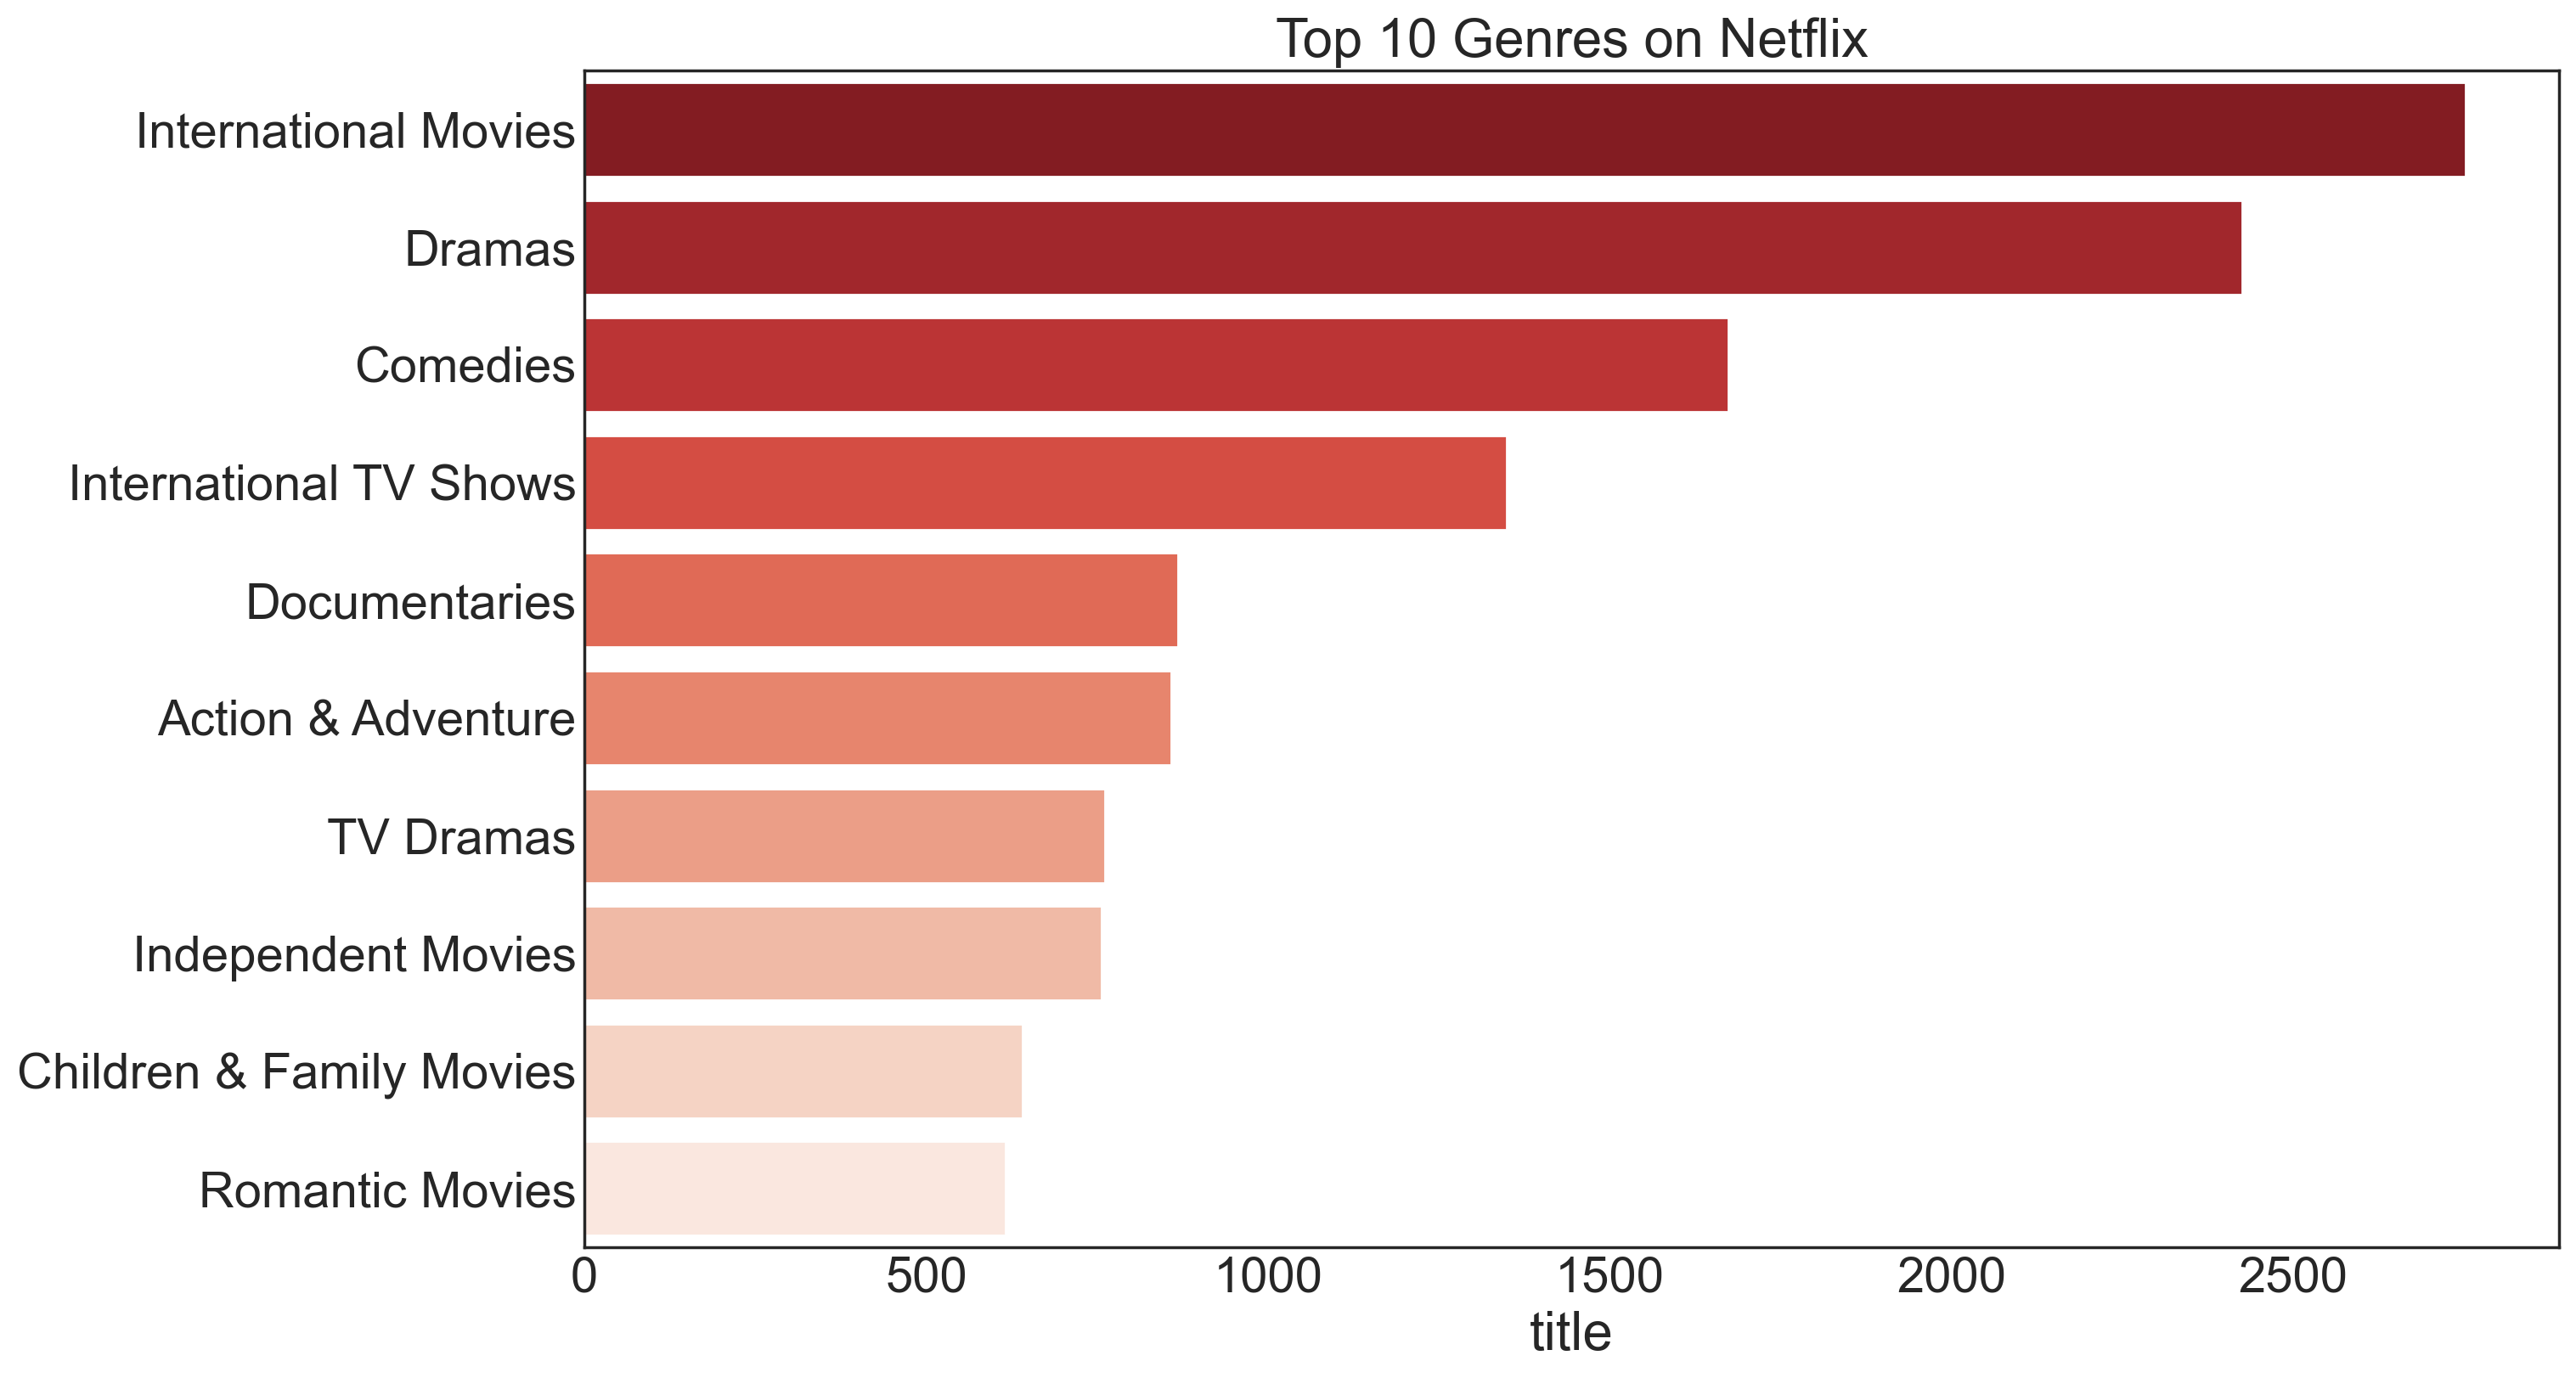

In [29]:
# Draw a barplot
genres_plt = sns.barplot(genres.head(10), y="Genre", x="title", palette="Reds_r")
genres_plt.set_title("Top 10 Genres on Netflix")
sns.set(font_scale=1.9)
genres_plt.set_ylabel("")
matplotlib.style.use("seaborn-white")

The most common genre on Netflix is International Movies. The next most common genres are Dramas and Comedies. I wonder if there would be a difference between the movies and TV shows in terms of common genres.

In [30]:
movie_tv_genres = netflix_new.groupby(["type", "Genre"])["title"].nunique().reset_index()
movie_tv_genres = movie_tv_genres.sort_values(by=["type", "title"], ascending=False)
movie_tv_genres.loc[movie_tv_genres["Genre"].str.contains("International"), "Genre"] = "International"
movie_tv_genres.loc[movie_tv_genres["Genre"].str.contains("Dramas"), "Genre"] = "Dramas"
movie_tv_genres.loc[movie_tv_genres["Genre"].str.contains("Comedies"), "Genre"] = "Comedies"
movie_tv_genres.loc[movie_tv_genres["Genre"].str.contains("Crime"), "Genre"] = "Crime"
movie_tv_genres.loc[movie_tv_genres["Genre"].str.contains("Kids"), "Genre"] = "Kids"
movie_tv_genres.head(5)

,type,Genre,title
25,TV Show,International,1349
35,TV Show,Dramas,762
34,TV Show,Comedies,573
23,TV Show,Crime,469
26,TV Show,Kids,448


C:\Users\eunbi\AppData\Local\Temp\ipykernel_25244\3348756340.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  matplotlib.style.use("seaborn-white")


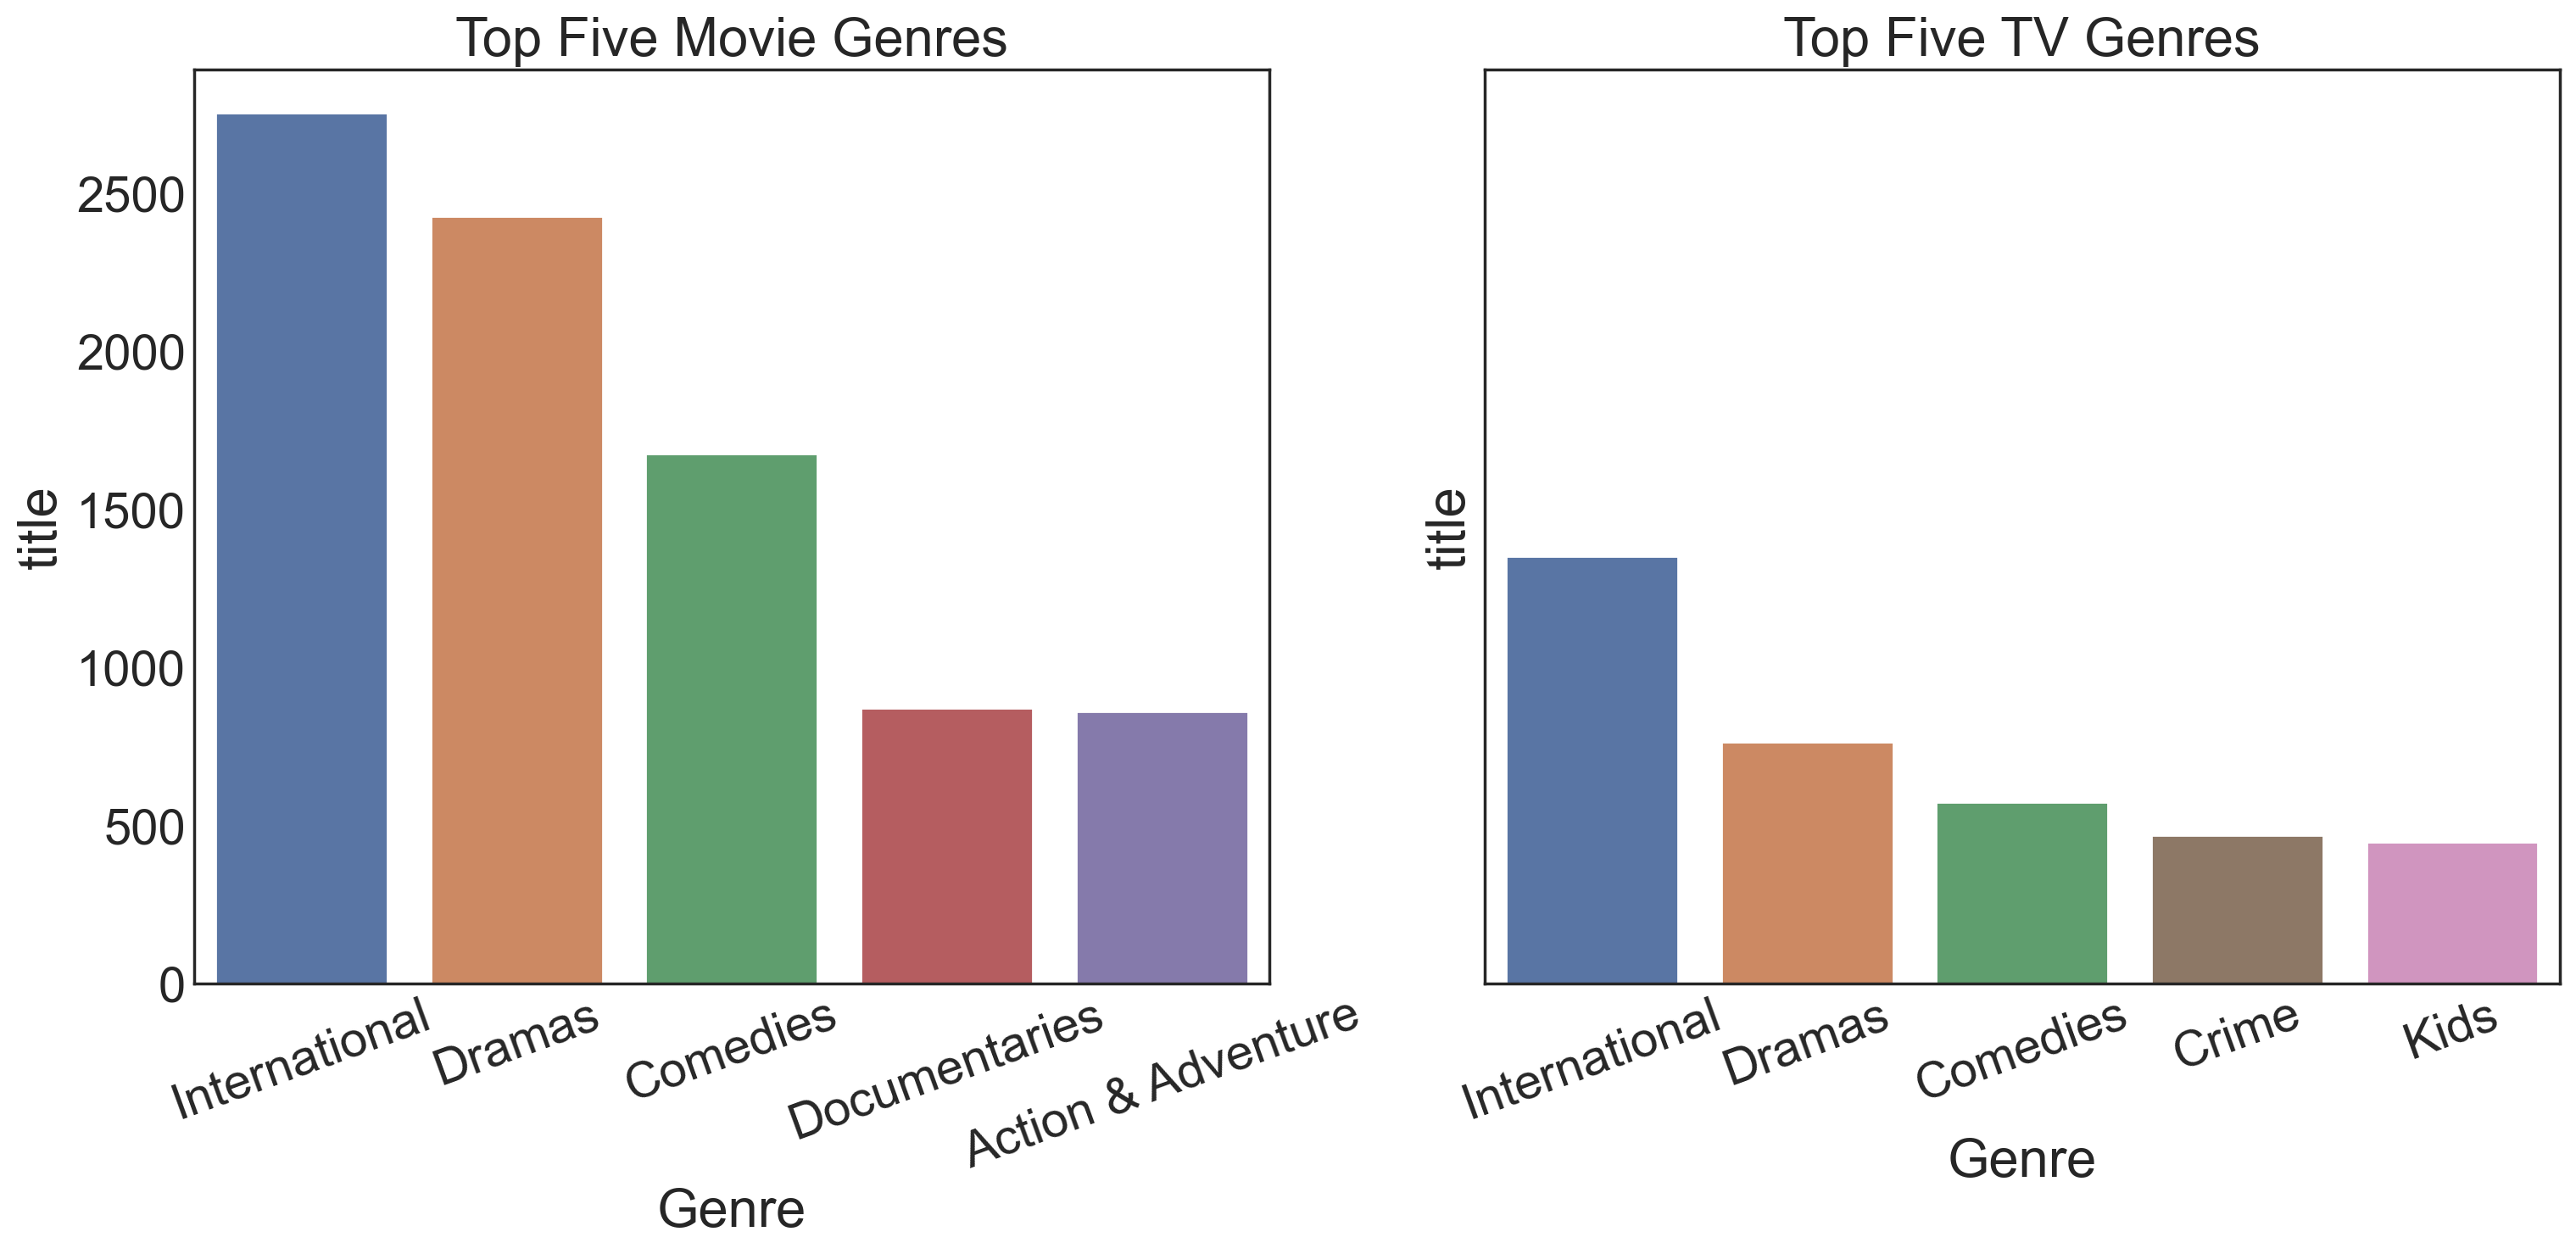

In [31]:
# Draw a barplot
palette ={"International": "C0", "Dramas": "C1", "Comedies": "C2", "Documentaries": "C3", 
          "Action & Adventure": "C4", "Crime" : "C5", "Kids" : "C6"}
fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
sns.barplot(movie_tv_genres.loc[movie_tv_genres["type"]=="Movie"].head(5), ax=axes[0], x="Genre", y="title", palette=palette)
axes[0].set_title("Top Five Movie Genres")
axes[0].tick_params(axis='x', rotation=20)
sns.barplot(movie_tv_genres.loc[movie_tv_genres["type"]=="TV Show"].head(5), ax=axes[1], x="Genre", y="title", palette=palette)
axes[1].set_title("Top Five TV Genres")
axes[1].tick_params(axis='x', rotation=20)
sns.set(font_scale=1.5)
matplotlib.style.use("seaborn-white")

The common genres of movies and TV shows seem to be similar. For both movies and TV shows, International, dramas and comedies are the most common genres. 

## What country mostly produces what genre?

Now, I wonder if certain genres of contents come from certain countries. For example, where do dramas mostly come from?

In [32]:
# ceate a pivot table by country and genre
topfive_genres = genres["Genre"].head(5).tolist()
country_genre = netflix_new.loc[(netflix_new["Genre"].isin(topfive_genres))&
                                (netflix_new["Country"]!="Unavailable")].groupby(["Country", "Genre"])["title"].nunique().reset_index()
country_genre = country_genre.sort_values(by=["Country", "title"], ascending=False)
country_genre = country_genre.loc[country_genre["Country"].isin(topfive_countries)].groupby(["Country"]).head(5)
country_genre.head(10)

,Country,Genre,title
378,United States,Dramas,835
376,United States,Comedies,680
377,United States,Documentaries,511
379,United States,International Movies,166
380,United States,International TV Shows,73
370,United Kingdom,Dramas,196
371,United Kingdom,International Movies,168
372,United Kingdom,International TV Shows,128
369,United Kingdom,Documentaries,127
368,United Kingdom,Comedies,91


C:\Users\eunbi\AppData\Local\Temp\ipykernel_25244\833652562.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  matplotlib.style.use("seaborn-white")


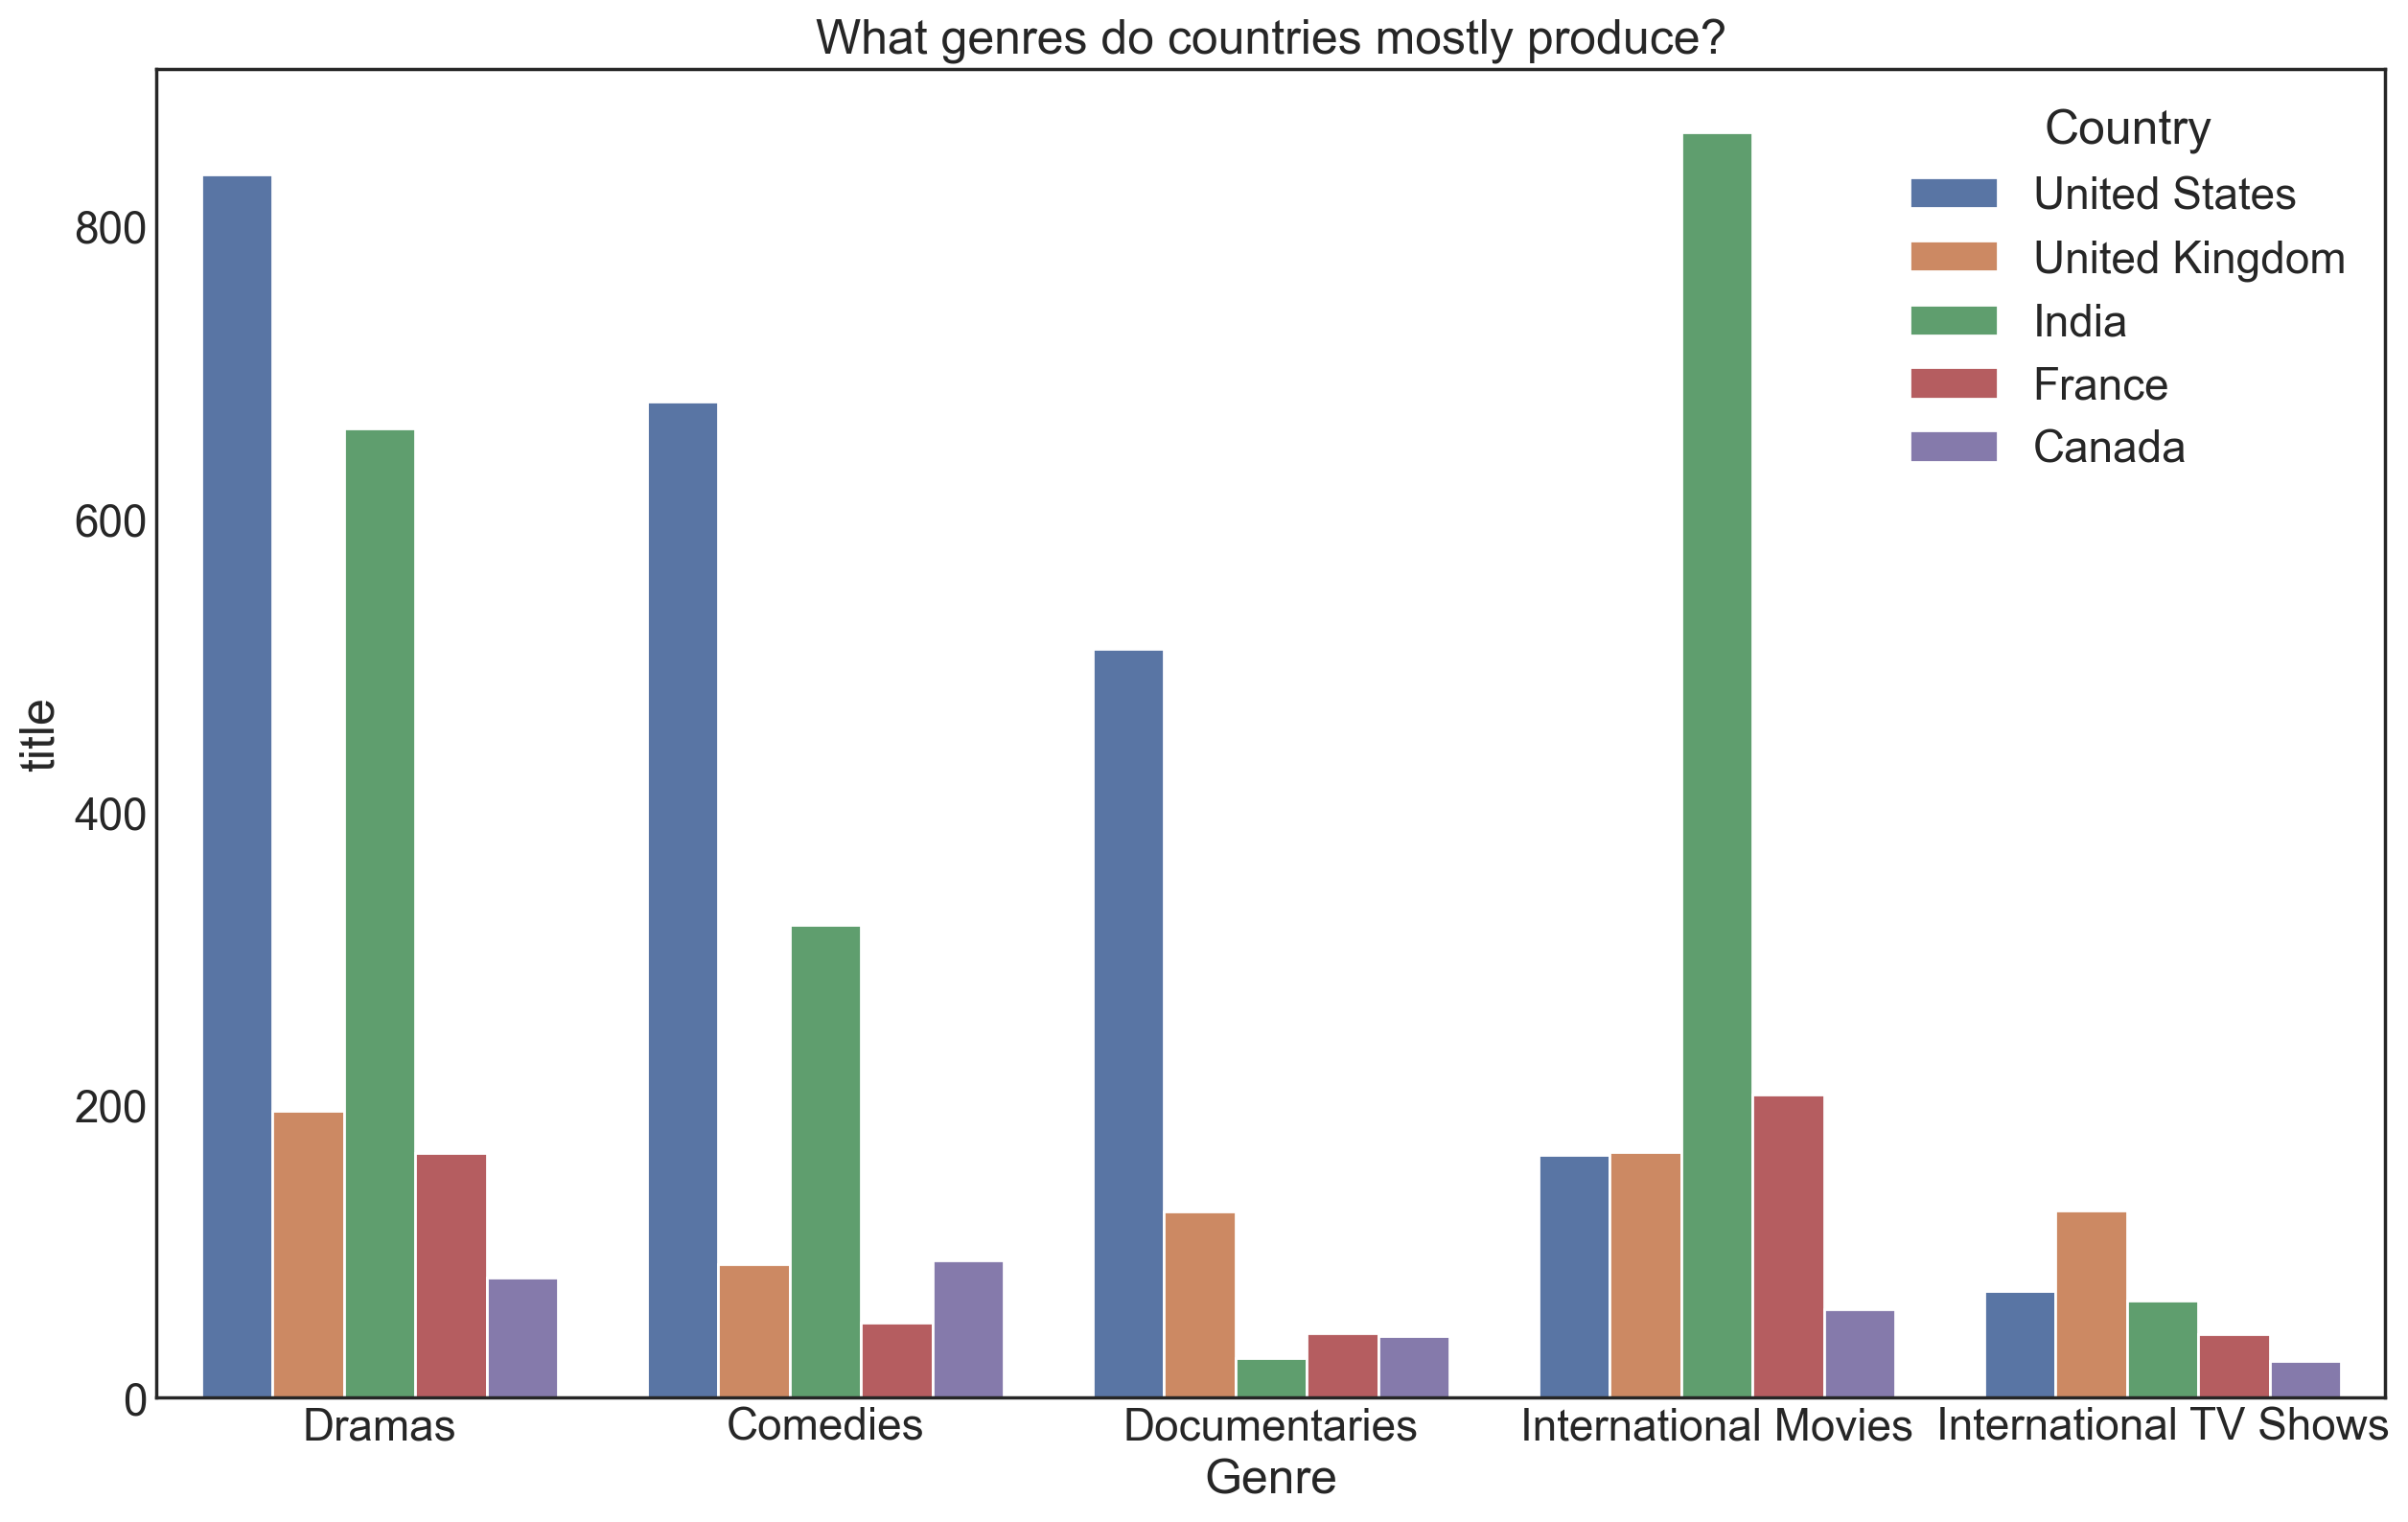

In [33]:
# draw a grouped  bar plot
country_genre_plt = sns.barplot(country_genre, x="Genre", y="title", hue="Country")
country_genre_plt.set_title("What genres do countries mostly produce?")
sns.set(font_scale=1.5)
matplotlib.style.use("seaborn-white")

Again, we can see that the US and India are the major content contributors regardless of genre. As for Dramas and Comedies, the first and second most popular genres on Netflix, the majority of the contents comes from the US and India. The major producer of Documentaries is the US, followed by the UK being the second biggest producer. We can see that India is the least producer of Documentaries, while it is the biggest producer of International movies. Lastly, as for International TV shows, the UK is the largest producer. 

## How are the ratings distributed?

I will group the data by 'type' and 'rating' to see how the ratings are distributed based on the number of titles.

In [34]:
# create a pivot table by rating and type
ratings = pd.pivot_table(netflix_new, index="rating", columns = "type", values = "title", 
                         aggfunc=pd.Series.nunique).reset_index()
ratings = ratings.fillna(0)
ratings.head()

type,rating,Movie,TV Show
0,G,41.0,0.0
1,NC-17,3.0,0.0
2,NR,75.0,4.0
3,PG,287.0,0.0
4,PG-13,490.0,0.0


Text(0.5, 0, 'Rating')

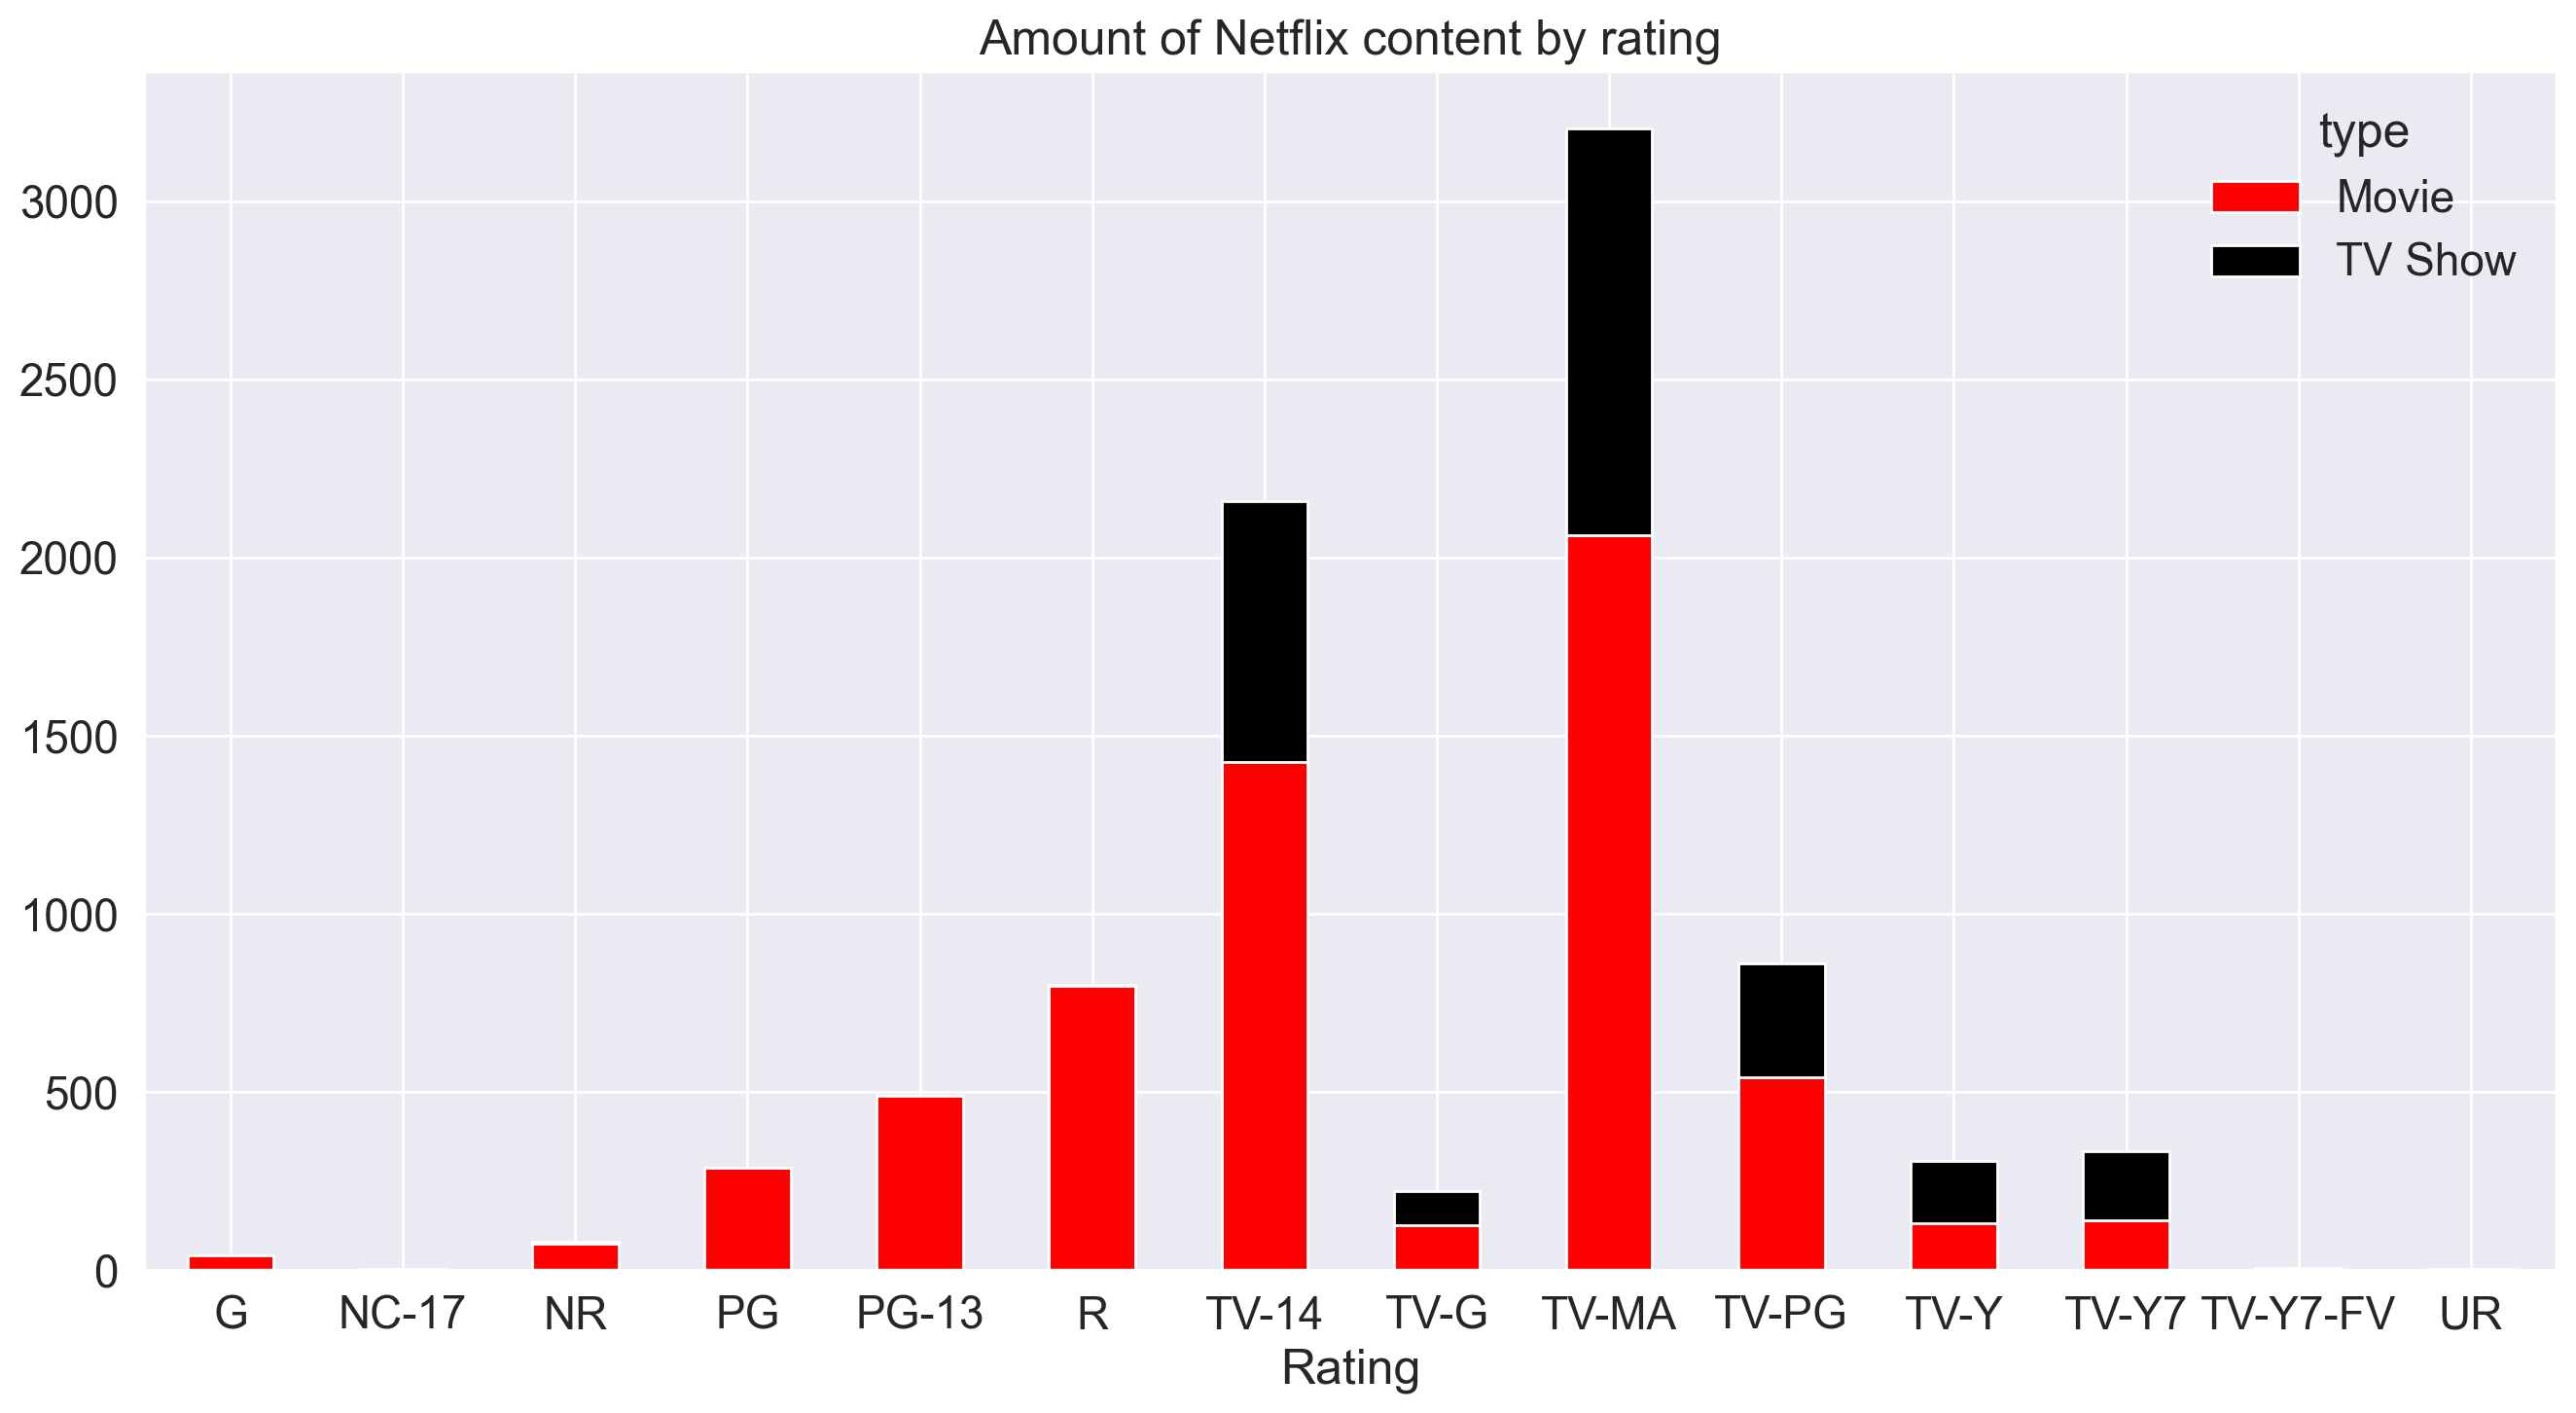

In [35]:
# Create a stacked bar chart
sns.set(style='white')
sns.set(font_scale=1.5)
ratings.set_index("rating").plot(kind='bar', stacked=True, color=['red', 'black'], figsize=(16, 8))
plt.title("Amount of Netflix content by rating")
plt.xticks(rotation=0)
plt.xlabel("Rating")

The largest count of Netflix content is rated “TV-MA". TV-MA” is a rating assigned by the TV Parental Guidelines to a television program designed for mature audiences only. The second largest count is rated “TV-14". “TV-14” contains material that parents or adult guardians may find unsuitable for children under the age of 14. The target audience of Netflix are mainly young adults and older adults.

## Who are the most popular actors on Netflix?

Some actors may star more frequently on Netflix contents than others. Now, I want to explore the top Actor on Netflix based on the number of titles.

In [36]:
# Top 10 actors
actors = netflix_new.loc[netflix_new["Actors"]!="Unavailable"].groupby(["Actors"])["title"].nunique().reset_index()
actors = actors.sort_values(by="title", ascending=False).reset_index()
actors = actors.drop("index", axis=1)
actors.head(10)

,Actors,title
0,Anupam Kher,43
1,Shah Rukh Khan,35
2,Julie Tejwani,33
3,Takahiro Sakurai,32
4,Naseeruddin Shah,32
5,Rupa Bhimani,31
6,Akshay Kumar,30
7,Om Puri,30
8,Yuki Kaji,29
9,Paresh Rawal,28


C:\Users\eunbi\AppData\Local\Temp\ipykernel_25244\3620370062.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  matplotlib.style.use("seaborn-white")


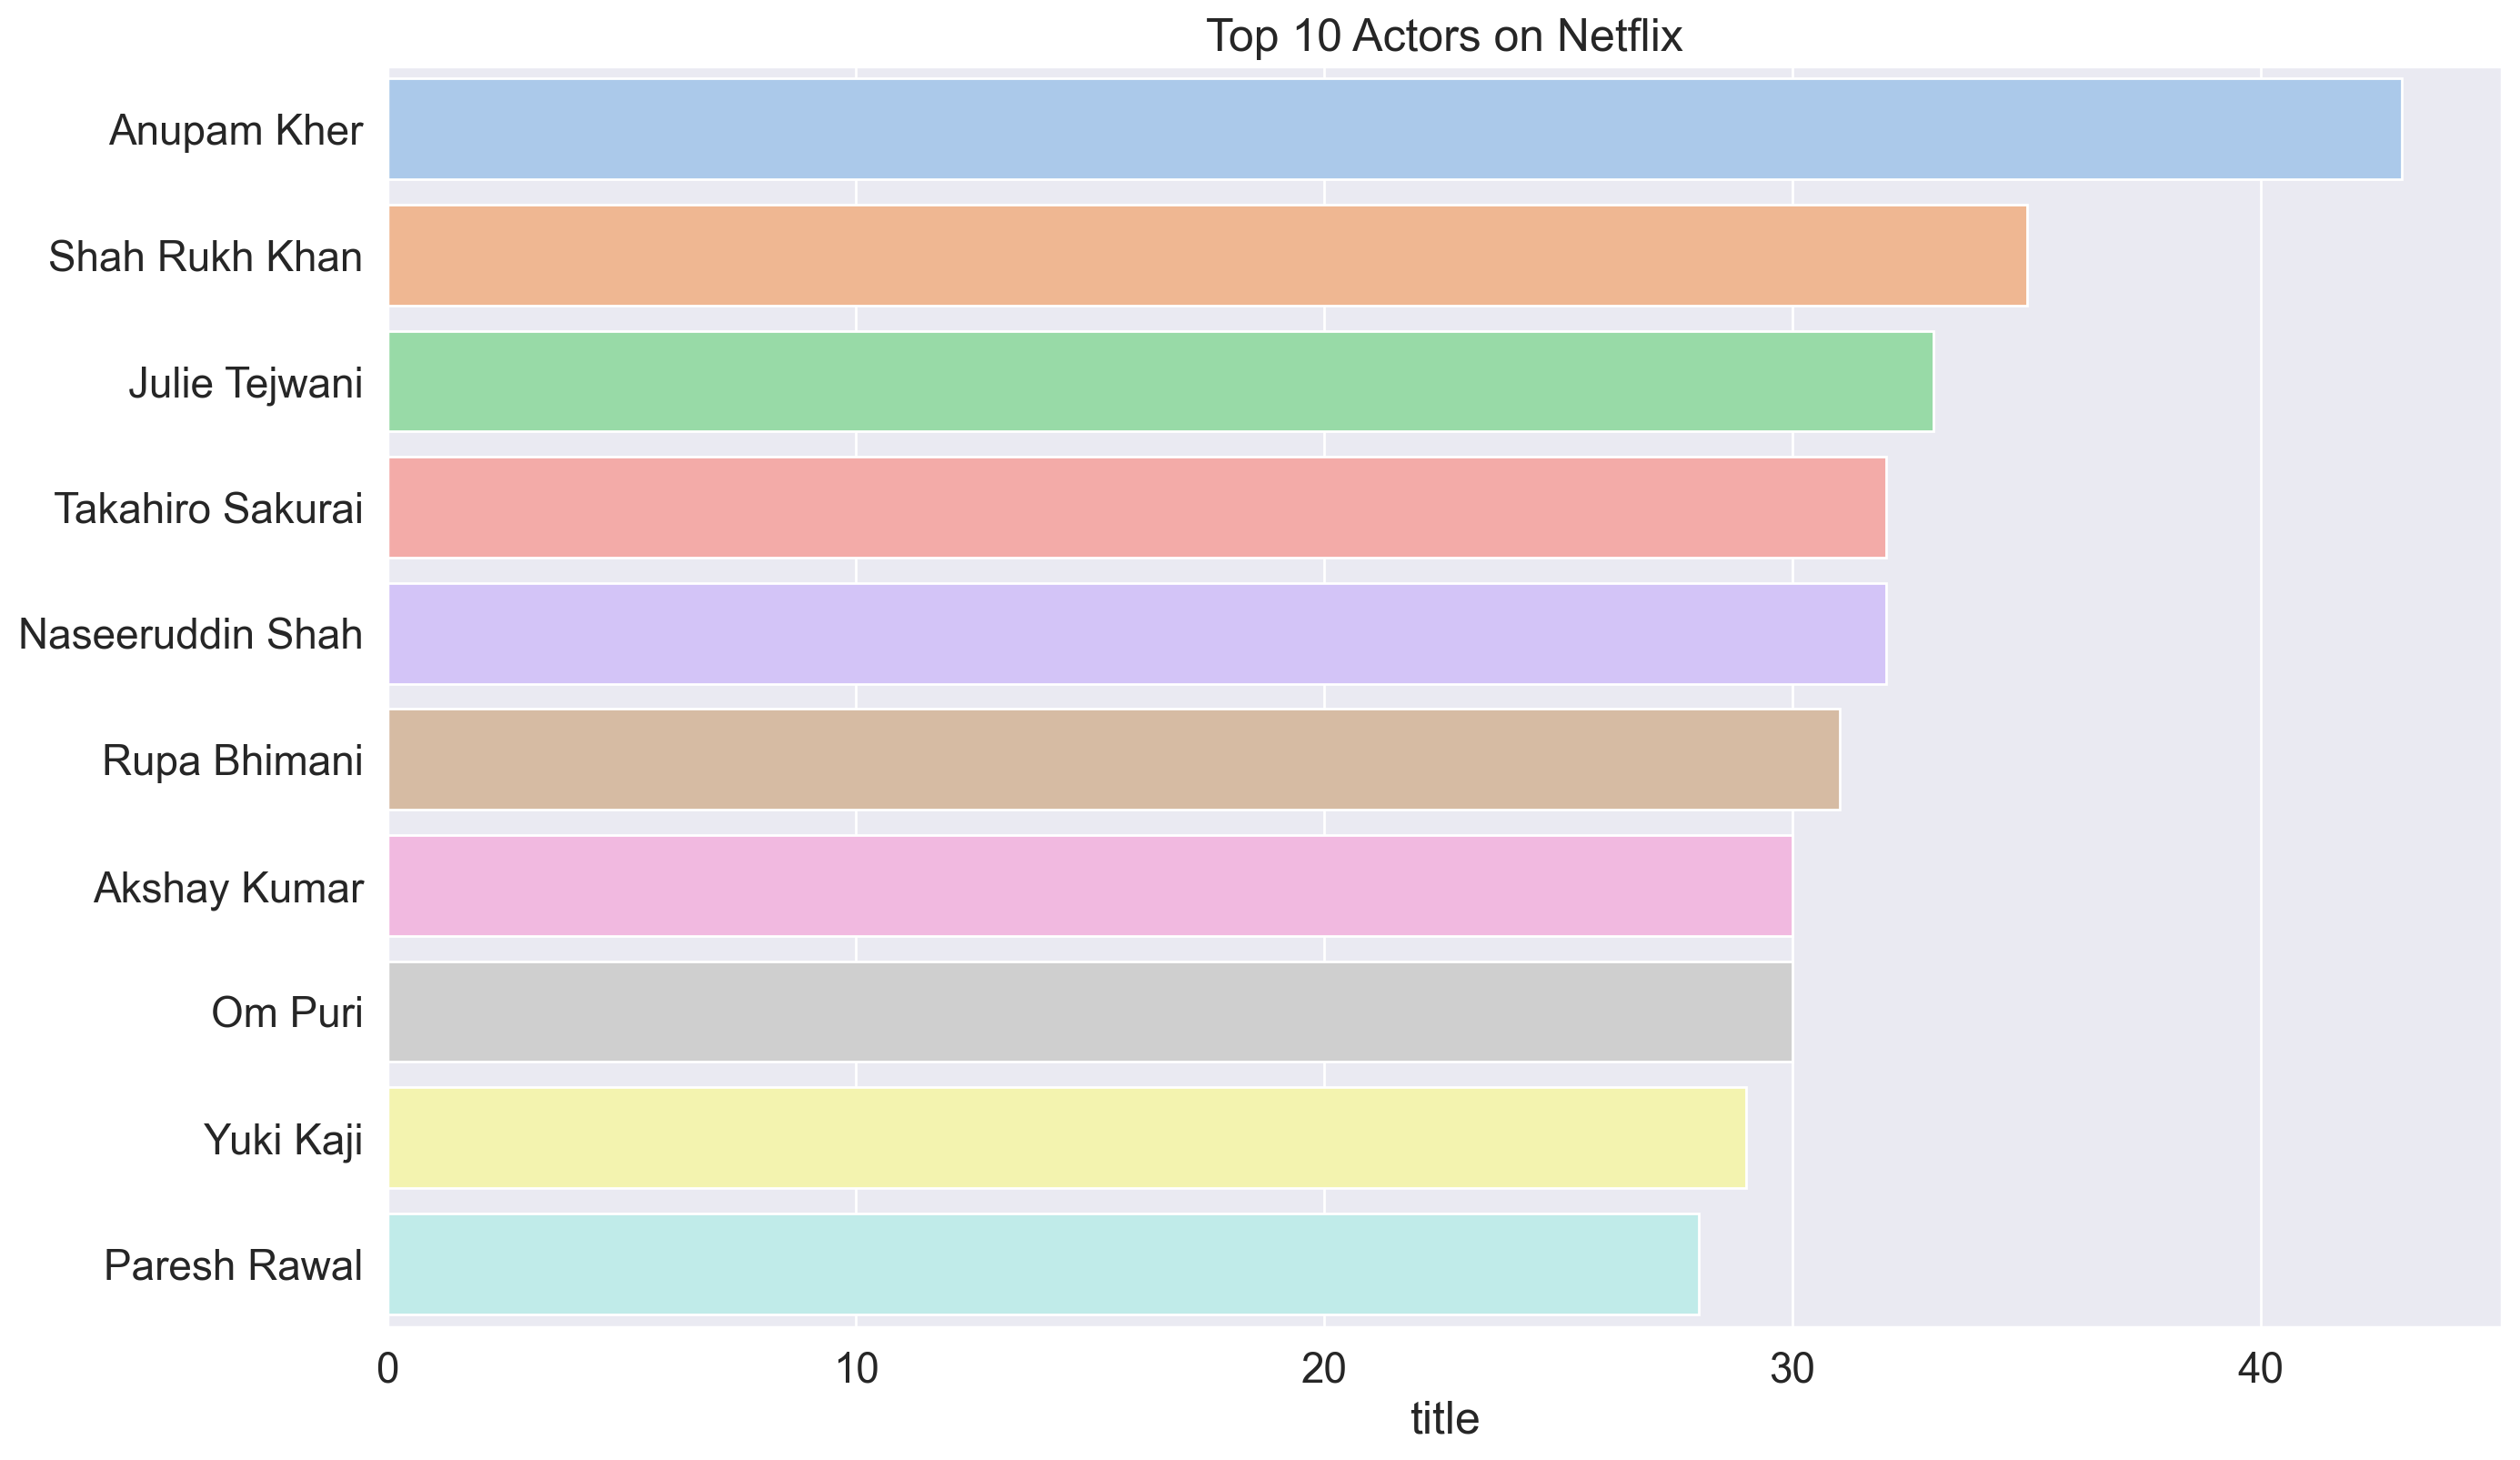

In [37]:
# Draw a barplot
actors_plt = sns.barplot(actors.head(10), y="Actors", x="title", palette="pastel")
actors_plt.set_title("Top 10 Actors on Netflix")
actors_plt.set_ylabel("")
sns.set(font_scale=1.9)
matplotlib.style.use("seaborn-white")

We can see that many indian actors appear on Netflix contents. The most popular actor on Netflix is an Indian actor, Anupam Kher. The next most popular actors are Shah Rukh Khan and Julie Tejwani.

## What words mostly appear on Netflix description?

The final thing I want to do is the text analysis of Netflix content descriptions. To do this, I will start by extracting "description" column from the data and converting it to a string.

In [38]:
description = netflix["description"].tolist()
description =str(description)
description = re.sub("[\"\-\[\]\'\.\?]", "", description)
description = description.replace(" ", ",")
description = re.sub(",{2,}", ",", description)

Now, I will create a wordcloud using WordCloud() function from wordcloud package. 

In [39]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
def wordcloud(data, width=1200, height=500):
    word_draw = WordCloud(
        font_path=r"C:\Windows\Fonts\Verdana.ttf",
        stopwords=STOPWORDS,
        width=width, height=height, 
        background_color="white",
        random_state=42
    )
    word_draw.generate(data)

    plt.figure(figsize=(16, 8))
    plt.imshow(word_draw)
    plt.axis("off")
    plt.show()

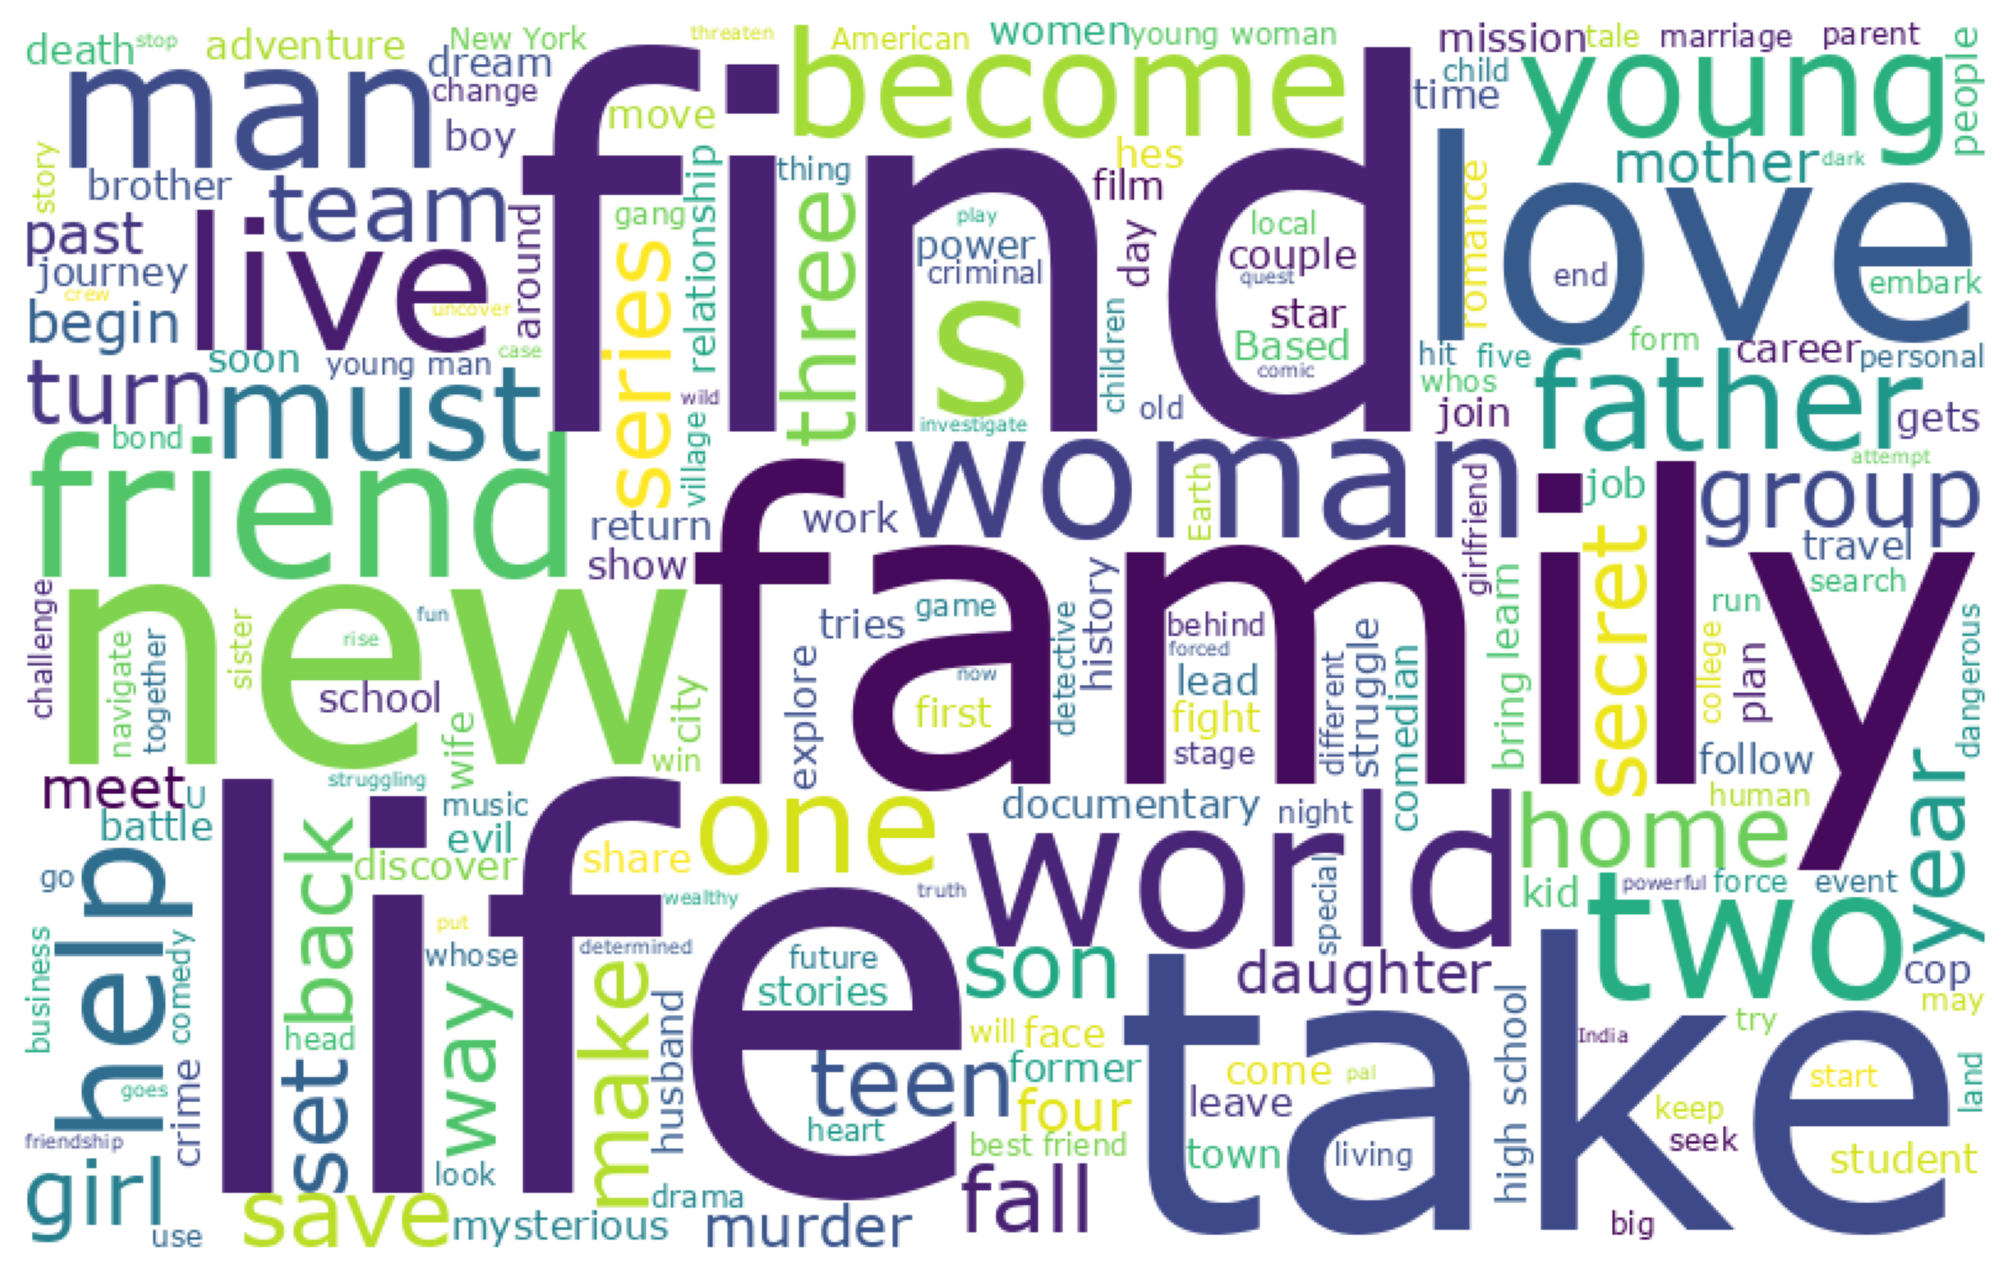

In [41]:
wordcloud(description, width=800, height=500)

Looking at the wordcloud above, the words 'find', 'life' and 'family' seem to be the most frequent words in the content descriptions. The words 'new', 'take', 'world' and 'love' also frequently appear.

# Conclusions

We have drawn many interesting inferences from the dataset. Here’s a summary of my analysis.

1. The majority content type on Netflix is movie.
2. Netflix started gaining traction after 2014. Since then, the amount of content added has been increasing significantly.
3. The country that produces the most amount of content is the United States.
4. The directors on Netflix is mainly international. The most popular director on Netflix, with the most titles, is Rajiv Chilaka.
5. The most popular genre on Netflix is International Movies.
6. The US and India are the major content contributors regardless of genre. 
7. The largest count of Netflix content is made with “TV-MA” rating as for both movies and TV shows.
8. The actors on Netflix is mainly international. The most popular actor on Netflix TV Shows, with the most titles, is Anupam Kher.
9. The most frequent words in the netflix content descriptions are about family, life and world.